In [1]:
%matplotlib inline

In [2]:
import os

In [3]:
%run notebook_setup

# Load data in from Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

In [4]:
import os
HOME = os.environ['HOME']
os.chdir(f'{HOME}/Research/Planets/WASP43/github_analysis/notebooks')

In [5]:
import exoplanet as xo
import joblib
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
import pymc3 as pm

from exomast_api import exoMAST_API
from statsmodels.robust.scale import mad
from time import time
# from tqdm import tqdm_notebook as tqdm

from arctor import create_raw_lc_stddev, Arctor, run_multiple_pymc3#, setup_and_plot_GTC
from arctor.utils import setup_and_plot_GTC
from arctor.utils import fit_2D_time_vs_other

In [6]:
def debug_message(message, end='\n'):
    print(f'[DEBUG] {message}', end=end)


def warning_message(message, end='\n'):
    print(f'[WARNING] {message}', end=end)


def info_message(message, end='\n'):
    print(f'[INFO] {message}', end=end)

In [7]:
plot_verbose = False
save_now = False
planet_name = 'WASP43'
file_type = 'flt.fits'

HOME = os.environ['HOME']
base_dir = os.path.join(HOME, 'Research', 'Planets', 'WASP43')
data_dir = os.path.join(base_dir, 'data', 'UVIS', 'MAST_2019-07-03T0738')
data_dir = os.path.join(data_dir, 'HST', 'FLTs')
working_dir = os.path.join(base_dir, 'github_analysis', 'savefiles')

In [8]:
planet = Arctor(planet_name, data_dir, working_dir, file_type)
joblib_filename = 'WASP43_savedict_206ppm_100x100_finescale.joblib.save'
save_dir = f'{HOME}/Research/Planets/savefiles'
joblib_filename = f'{save_dir}/{joblib_filename}'
planet.load_dict(joblib_filename)

[INFO] Initializing Instance of the `Arctor` Object


In [9]:
planet.photometry_df.columns

Index(['aperture_sum_11x41', 'aperture_sum_12x41', 'aperture_sum_13x41',
       'aperture_sum_14x41', 'aperture_sum_15x41', 'aperture_sum_16x41',
       'aperture_sum_17x41', 'aperture_sum_18x41', 'aperture_sum_19x41',
       'aperture_sum_20x41',
       ...
       'aperture_sum_23x60', 'aperture_sum_24x60', 'aperture_sum_25x60',
       'aperture_sum_26x60', 'aperture_sum_27x60', 'aperture_sum_28x60',
       'aperture_sum_29x60', 'aperture_sum_30x60', 'xcenter', 'ycenter'],
      dtype='object', length=402)

In [10]:
if not hasattr(planet, 'photometry_df'):
    # planet.load_dict(joblib_filename)
    planet.clean_cosmic_rays()
    planet.calibration_trace_location()
    planet.identify_trace_direction()
    planet.simple_phots()
    planet.center_all_traces()
    planet.fit_trace_slopes()
    planet.compute_sky_background(subpixels=32)
    planet.compute_columnwise_sky_background()

# Run Multi-Phot

In [11]:
if not hasattr(planet, 'photometry_df'):
    # Set up the list of aperture widths and heights to search
    min_aper_width = 1
    max_aper_width = 100
    min_aper_height = 1
    max_aper_height = 100

    aper_widths = np.arange(min_aper_width, max_aper_width + 2, 5)
    aper_heights = np.arange(min_aper_height, max_aper_height + 2, 5)
    
    planet.do_multi_phot(aper_widths, aper_heights)

# Determine the 'best' photometry SNR

In [12]:
med_photometry_df = np.median(planet.photometry_df, axis=0)
planet.normed_photometry_df = planet.photometry_df / med_photometry_df
planet.normed_uncertainty_df = np.sqrt(planet.photometry_df) / med_photometry_df

In [13]:
planet_fine_photometry_df = planet.photometry_df.copy()

In [14]:
fine_snr_lightcurves = create_raw_lc_stddev(planet)
fine_min_snr = fine_snr_lightcurves[fine_snr_lightcurves.argmin()]
fine_min_snr_colname = planet.photometry_df.columns[fine_snr_lightcurves.argmin()]
fine_min_snr_flux = planet.normed_photometry_df[fine_min_snr_colname]
fine_min_snr_uncs = planet.normed_uncertainty_df[fine_min_snr_colname]
fine_temp = fine_min_snr_colname.split('_')[-1].split('x')
fine_min_snr_aper_width, fine_min_snr_aper_height = np.int32(fine_temp)

In [15]:
info_message(f'Fine Aperture Photometry Resulted in {fine_min_snr:0.0f}ppm with '
             f'{fine_min_snr_aper_width}x{fine_min_snr_aper_height} aperture size; '
             f'with median uncertainties of {np.median(fine_min_snr_uncs)*1e6:0.0f} ppm')

[INFO] Fine Aperture Photometry Resulted in 209ppm with 20x50 aperture size; with median uncertainties of 126 ppm


# Configure system for PyMC3

In [16]:
idx_fwd = planet.idx_fwd
idx_rev = planet.idx_rev

In [17]:
# Compute a limb-darkened light curve using starry
times = planet.times
u = []
flux = planet.normed_photometry_df[fine_min_snr_colname]
yerr = planet.normed_uncertainty_df[fine_min_snr_colname]

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [18]:
print(f'This instance has {mp.cpu_count()} CPUs')

This instance has 16 CPUs


In [19]:
wasp43 = exoMAST_API('WASP43b')
t0_wasp43 = wasp43.transit_time  # 55528.3684  # exo.mast.stsci.edu
period_wasp43 = wasp43.orbital_period
n_epochs = np.int(np.round(((np.median(times) - t0_wasp43) / period_wasp43)-0.5))
t0_guess = t0_wasp43 + (n_epochs+0.5) * period_wasp43

In [20]:
b_wasp43 = wasp43.impact_parameter # 0.66 # Hellier 2011
u = [0]
edepth = np.sqrt(500/1e6)

orbit_wasp43 = xo.orbits.KeplerianOrbit(period=period_wasp43, t0=t0_guess, b=b_wasp43)
injected_light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit_wasp43, r=edepth, t=times).eval().flatten()

# Run 400 MCMCs

In [21]:
fine_snr_flux = planet.normed_photometry_df
fine_snr_uncs = planet.normed_uncertainty_df

n_columns = len(fine_snr_flux.columns)

aper_sum_columns = planet.normed_photometry_df.drop(
    ['xcenter', 'ycenter'], axis=1).columns

xcenters = planet.photometry_df['xcenter']
ycenters = planet.photometry_df['ycenter']
xcenters_mod = xcenters - np.median(xcenters)
ycenters_mod = ycenters - np.median(ycenters)
times_mod = times - t0_guess#np.median(times)

In [22]:
n_space = 2
near_best_apertures_NxN_small = [f'aperture_sum_{aper_width_}x{aper_height_}' 
                       for aper_width_ in (np.arange(-n_space+1,n_space)+fine_min_snr_aper_width)
                       for aper_height_ in (np.arange(-n_space+1,n_space)+fine_min_snr_aper_height)]

In [23]:
near_best_apertures_NxN_small,len(near_best_apertures_NxN_small)

(['aperture_sum_19x49',
  'aperture_sum_19x50',
  'aperture_sum_19x51',
  'aperture_sum_20x49',
  'aperture_sum_20x50',
  'aperture_sum_20x51',
  'aperture_sum_21x49',
  'aperture_sum_21x50',
  'aperture_sum_21x51'],
 9)

# RUN ALL 12 IN ONE FUNCTION

# RUN ALL 12 MANUALLY

# Combine all 12 manually

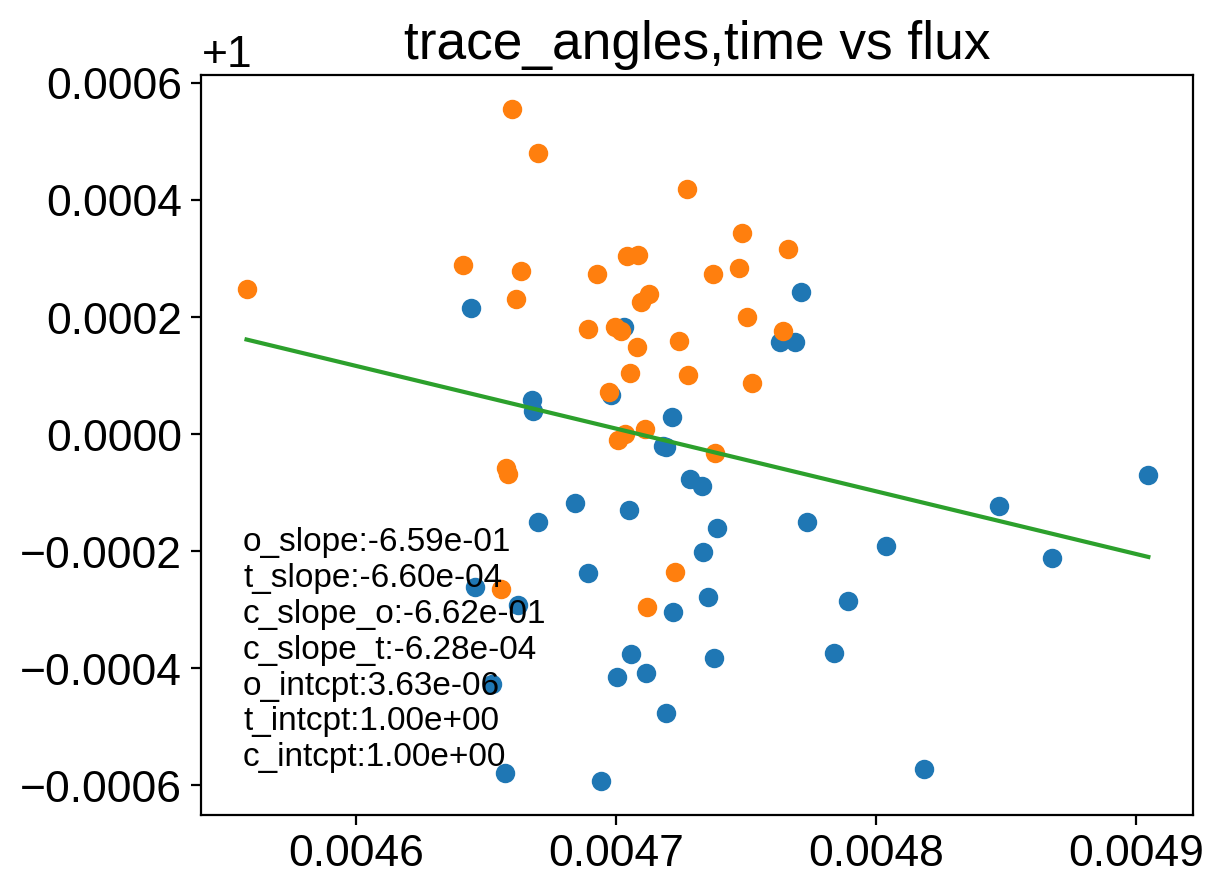

In [24]:
flux = planet.normed_photometry_df[fine_min_snr_colname]
trace_angles = planet.trace_angles
fit_2D_time_vs_other(times, flux, trace_angles, idx_fwd, idx_rev, 
                     label='trace_angles,time vs flux', n_sig=3)

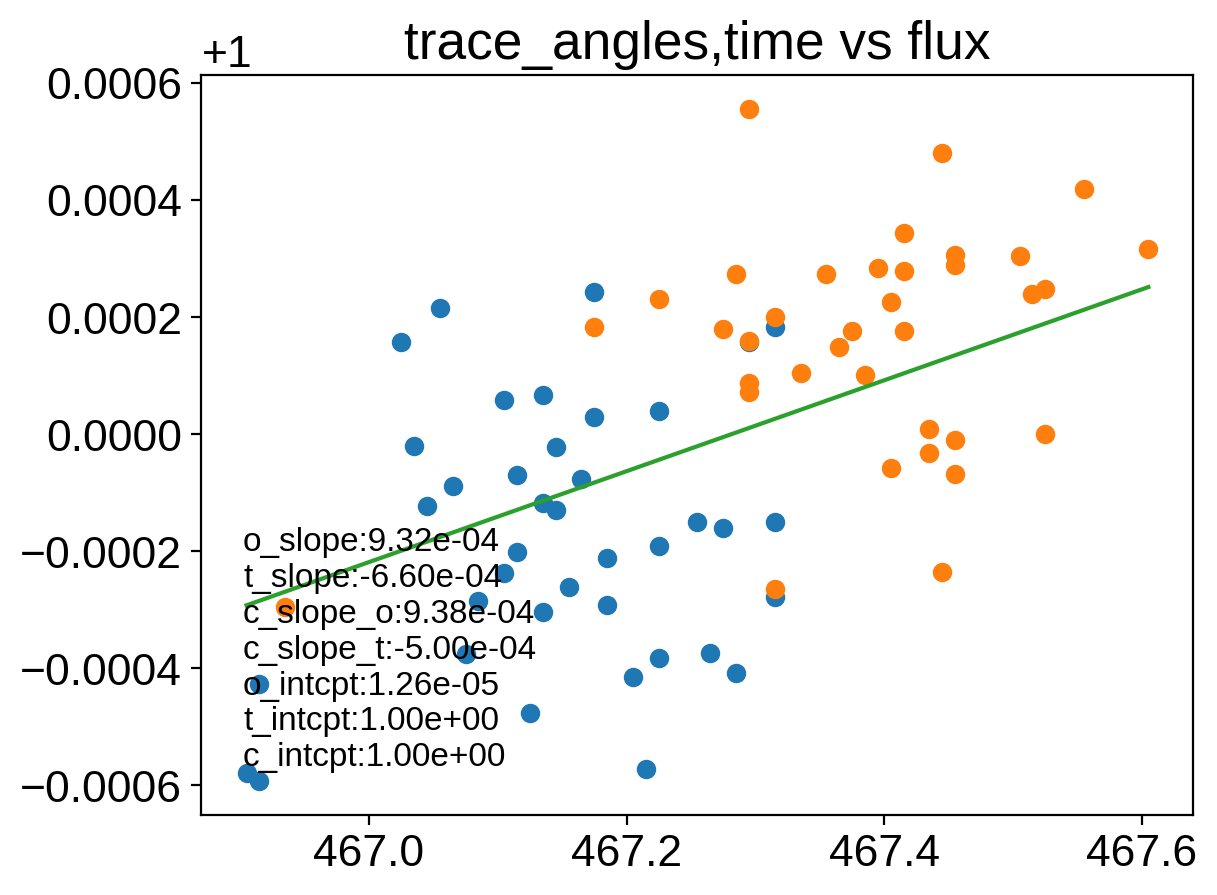

In [25]:
flux = planet.normed_photometry_df[fine_min_snr_colname]
trace_lengths = planet.trace_lengths
fit_2D_time_vs_other(times, flux, trace_lengths, idx_fwd, idx_rev, 
                     label='trace_angles,time vs flux', n_sig=3)

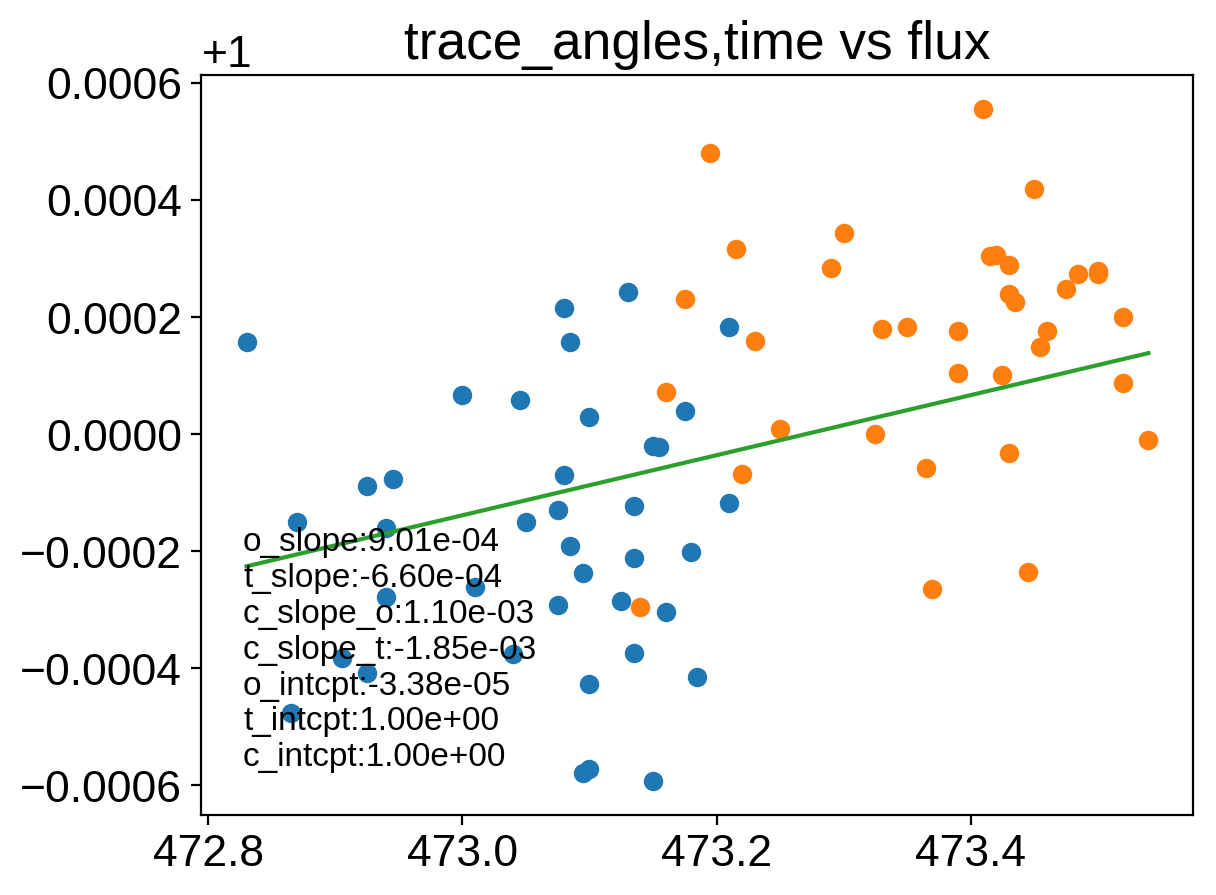

In [26]:
flux = planet.normed_photometry_df[fine_min_snr_colname]
trace_angles = planet.trace_angles
fit_2D_time_vs_other(times, flux, xcenters, idx_fwd, idx_rev, 
                     label='trace_angles,time vs flux', n_sig=3)

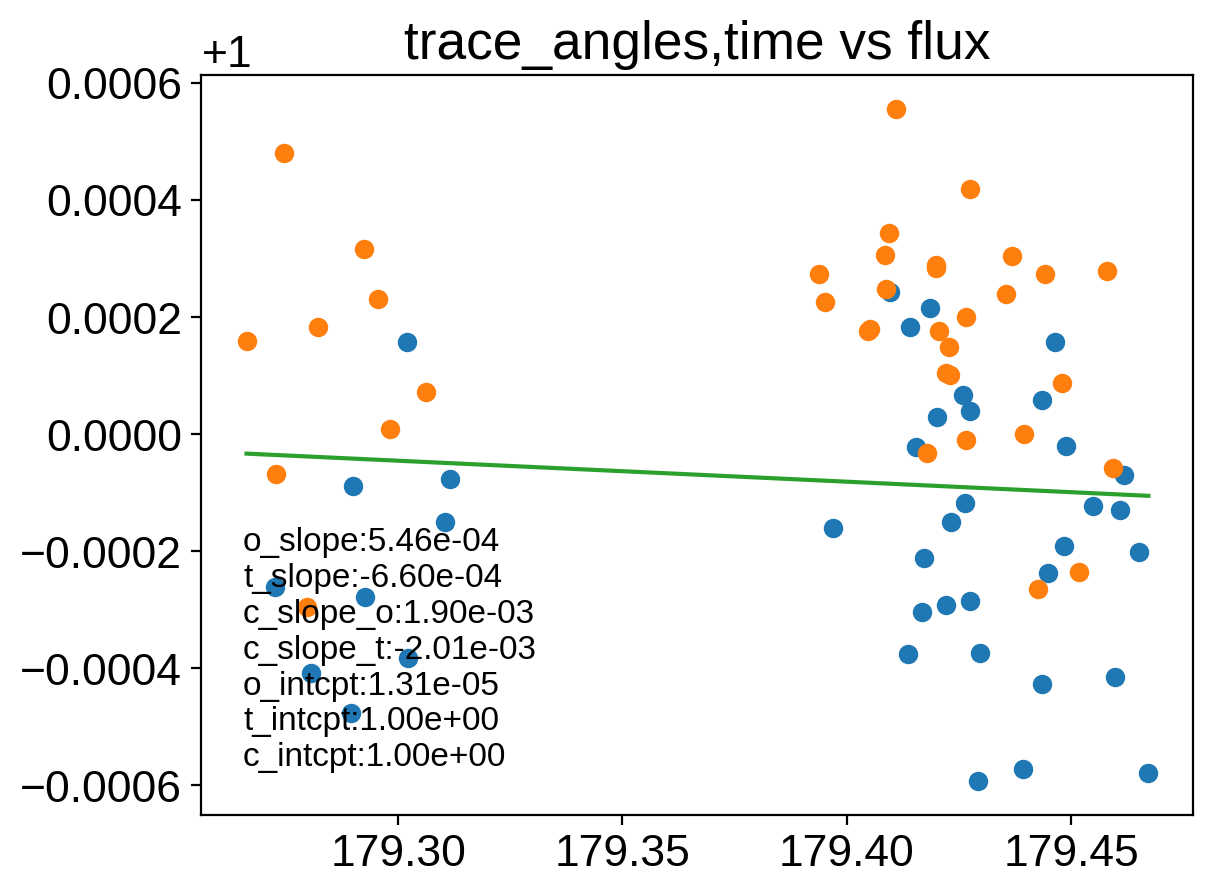

In [27]:
flux = planet.normed_photometry_df[fine_min_snr_colname]
trace_angles = planet.trace_angles
fit_2D_time_vs_other(times, flux, ycenters, idx_fwd, idx_rev, 
                     label='trace_angles,time vs flux', n_sig=3)

# Testing new "all correlations and all flavors" MCMC

In [28]:
def compute_sdnr(map_soln, phots, idx_fwd, idx_rev):
    ppm = 1e6
    phots_std_fwd = phots[idx_fwd].std()
    phots_std_rev = phots[idx_rev].std()
    phots_std = np.mean([phots_std_fwd, phots_std_rev])
    
    if 'mean_fwd' not in map_soln.keys():
        map_model = map_soln['light_curves'].flatten() + map_soln['line_model']
    else:
        map_model = np.zeros_like(times)
        map_model[idx_fwd] = map_soln['light_curves_fwd'].flatten() + map_soln['line_model_fwd']
        map_model[idx_rev] = map_soln['light_curves_rev'].flatten() + map_soln['line_model_rev']
    
    varnames = [key for key in map_soln.keys() if '__' not in key and 'light' not in key and 'line' not in key and 'le_edepth_0' not in key]
    
    res_fwd = np.std(map_model[idx_fwd] - phots[idx_fwd])
    res_rev = np.std(map_model[idx_rev] - phots[idx_rev])
    res_std = np.mean([res_fwd, res_rev])
    
    print(f'{str(varnames):<80}')
    print(f'{res_std*ppm:0.2f}, {phots_std*ppm:0.2f}, {(phots_std - res_std)*ppm:0.2f} ppm difference'),
    
    return res_std*ppm, phots_std*ppm, (phots_std - res_std)*ppm

# HERE

In [33]:
save_dir = os.path.join(HOME, 'Research', 'Planets', 'WASP43', 'github_analysis', 'notebooks', 'all400_results_decor_MAPs_only_SDNR')

In [ ]:
from arctor.utils import run_pymc3_both

tune = 3000
draws = 3000
target_accept = 0.9
do_mcmc = True
idx_fwd_ = None
idx_rev_ = None
use_log_edepth = False
allow_negative_edepths = False

xcenters_mod = planet.trace_xcenters - np.median(planet.trace_xcenters)
ycenters_mod = planet.trace_ycenters - np.median(planet.trace_ycenters)
trace_angles_mod = planet.trace_angles - np.median(planet.trace_angles)
trace_lengths_mod = planet.trace_lengths - np.median(planet.trace_lengths)
phots = planet.normed_photometry_df[fine_min_snr_colname].values

# n_space = 10
# near_best_apertures_NxN_small = [f'aperture_sum_{aper_width_}x{aper_height_}' 
#                                  for aper_width_ in (np.arange(-n_space//2+1, n_space//2+1)+fine_min_snr_aper_width)
#                                  for aper_height_ in (np.arange(-n_space//2+1, n_space//2+1)+fine_min_snr_aper_height)]
# # len(near_best_apertures_NxN_small)# near_best_apertures_NxN_small
save_dir = os.path.join(HOME, 'Research', 'Planets', 'WASP43', 'github_analysis', 'notebooks', 'all400_results_decor_MAPs_only_SDNR')

decor_span_MAPs_only_list_all400 = []
startn1 = time()
for aper_column in planet.normed_photometry_df.columns:  # near_best_apertures_NxN_small:  # [fine_min_snr_colname]:
    phots = planet.normed_photometry_df[aper_column].values
    uncs = planet.normed_uncertainty_df[aper_column].values
    save_state = {}
    save_state[aper_column] = []
    start0 = time()
    for idx_fwd_, idx_rev_ in zip([None, idx_fwd], [None, idx_rev]):
        start1 = time()
        for xcenters_ in [None, xcenters_mod]:
            start2 = time()
            for ycenters_ in [None, ycenters_mod]:
                start3 = time()
                for trace_angles_ in [None, trace_angles_mod]:
                    start4 = time()
                    for trace_lengths_ in [None, trace_lengths_mod]:
                        start5 = time()
                        fine_grain_mcmcs, map_soln = run_pymc3_both(
                            times, phots, uncs,
                            t0=t0_guess, u=u, period=period_wasp43, b=b_wasp43,
                            tune=tune, draws=draws, target_accept=target_accept,
                            xcenters=xcenters_,
                            ycenters=ycenters_,
                            trace_angles=trace_angles_,
                            trace_lengths=trace_lengths_,
                            do_mcmc=False,
                            idx_fwd=idx_fwd_,
                            idx_rev=idx_rev_,
                            use_log_edepth=use_log_edepth,
                            allow_negative_edepths=allow_negative_edepths)

                        info_message(f'Full decorrelation took {(time() - start5)/60:0.2f} minutes')
                        res_std_ppm, phots_std_ppm, res_diff_ppm = compute_sdnr(map_soln, phots, idx_fwd, idx_rev)
                        
                        save_state_ = [idx_fwd_ is not None,
                                       idx_rev_ is not None,
                                       xcenters_ is not None,
                                       ycenters_ is not None,
                                       trace_angles_ is not None,
                                       trace_lengths_ is not None]
                        
                        save_state_.extend([fine_grain_mcmcs, map_soln])
                        save_state_.extend([res_std_ppm, phots_std_ppm, res_diff_ppm])
                        
                        save_state[aper_column].append(save_state_)
                        # decor_span_MAPs_only_list_all400.append(save_state)
                        
                    info_message(f'Trace Length Option took {(time() - start4)/60:0.2f} minutes')
                info_message(f'Trace Angle Option took {(time() - start3)/60:0.2f} minutes')
            info_message(f'Ycenter Option took {(time() - start2)/60:0.2f} minutes')
        info_message(f'Xcenter Option took {(time() - start1)/60:0.2f} minutes')
    info_message(f'Run through for {aper_column} took {(time() - start0)/60:0.2f} minutes')
    save_name = f'{save_dir}/results_decor_span_MAPs_only_SDNR_{aper_column}.joblib.save'
    
    print(f'[INFO] Saving {aper_column} to {save_name}')
    joblib.dump(save_state, save_name)
    del save_state
info_message(f'Entire loop-d-loop took {(time() - startn1)/60:0.2f} minutes')

# joblib.dump(decor_span_MAPs_only_list_all400, f'{save_dir}/results_decor_span_MAPs_only_SDNR_all400.joblib.save')

optimizing logp for variables: [slope, edepth, mean]
86it [00:00, 152.53it/s, logp=4.338151e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14789.495098418858 -> 433.81506885728805


[INFO] Map Soln Edepth:8.159649347445775
[INFO] Full decorrelation took 0.18 minutes
['mean', 'edepth', 'slope']                                                     
206.29, 210.07, 3.77 ppm difference


optimizing logp for variables: [slope_trace_length, slope, edepth, mean]
31it [00:00, 73.21it/s, logp=4.843032e+02] 
message: Optimization terminated successfully.
logp: -14790.881392779977 -> 484.30317437200506


[INFO] Map Soln Edepth:10.438077175975808
[INFO] Full decorrelation took 0.03 minutes
['mean', 'edepth', 'slope', 'slope_trace_length']                               
207.09, 210.07, 2.98 ppm difference
[INFO] Trace Length Option took 0.21 minutes


optimizing logp for variables: [slope_trace_angle, slope, edepth, mean]
285it [00:00, 297.41it/s, logp=4.348352e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14790.881392779977 -> 434.8352068614361


[INFO] Map Soln Edepth:8.667785720010125
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_trace_angle']                                
208.79, 210.07, 1.27 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope, edepth, mean]
184it [00:00, 233.88it/s, logp=4.835959e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14792.267687141097 -> 483.5959134490685


[INFO] Map Soln Edepth:10.836346247093305
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_trace_angle', 'slope_trace_length']          
207.02, 210.07, 3.05 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.30 minutes


optimizing logp for variables: [slope_ycenter, slope, edepth, mean]
87it [00:00, 171.96it/s, logp=4.449226e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14790.881392779977 -> 444.92263812414535


[INFO] Map Soln Edepth:10.583504171327387
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter']                                    
184.01, 210.07, 26.05 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope, edepth, mean]
32it [00:00, 82.51it/s, logp=4.976028e+02] 
message: Optimization terminated successfully.
logp: -14792.267687141097 -> 497.6027965071323


[INFO] Map Soln Edepth:15.07435084090251
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_length']              
190.45, 210.07, 19.62 ppm difference
[INFO] Trace Length Option took 0.07 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope, edepth, mean]
153it [00:00, 224.54it/s, logp=4.473969e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14792.267687141097 -> 447.39691155031034


[INFO] Map Soln Edepth:11.86102957909261
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle']               
186.23, 210.07, 23.83 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope, edepth, mean]
96it [00:00, 161.94it/s, logp=4.978479e+02]
message: Optimization terminated successfully.
logp: -14793.653981502217 -> 497.8478668914785


[INFO] Map Soln Edepth:16.568515556455278
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
189.73, 210.07, 20.34 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.16 minutes
[INFO] Ycenter Option took 0.47 minutes


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
122it [00:00, 206.90it/s, logp=5.104988e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14790.881392779977 -> 510.49876024510144


[INFO] Map Soln Edepth:10.220085502954726
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter']                                    
186.34, 210.07, 23.73 ppm difference


optimizing logp for variables: [slope_trace_length, slope_xcenter, slope, edepth, mean]
33it [00:00, 82.88it/s, logp=5.112616e+02] 
message: Optimization terminated successfully.
logp: -14792.267687141097 -> 511.2615792888773


[INFO] Map Soln Edepth:10.605005947124136
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_length']              
183.27, 210.07, 26.80 ppm difference
[INFO] Trace Length Option took 0.08 minutes


optimizing logp for variables: [slope_trace_angle, slope_xcenter, slope, edepth, mean]
99it [00:00, 176.89it/s, logp=5.092623e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14792.267687141097 -> 509.2623015492043


[INFO] Map Soln Edepth:10.053372293569367
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle']               
186.22, 210.07, 23.85 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_xcenter, slope, edepth, mean]
109it [00:00, 178.17it/s, logp=5.099560e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14793.653981502217 -> 509.95598144172124


[INFO] Map Soln Edepth:10.467762226819163
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length']
183.21, 210.07, 26.86 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.16 minutes


optimizing logp for variables: [slope_ycenter, slope_xcenter, slope, edepth, mean]
129it [00:00, 207.85it/s, logp=5.200760e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14792.267687141097 -> 520.0760065692173


[INFO] Map Soln Edepth:13.736024916811443
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter']                   
174.29, 210.07, 35.78 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope_xcenter, slope, edepth, mean]
106it [00:00, 171.36it/s, logp=5.217272e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14793.653981502217 -> 521.7271793029597


[INFO] Map Soln Edepth:14.748342333488216
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length']
170.57, 210.07, 39.50 ppm difference
[INFO] Trace Length Option took 0.09 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean]
129it [00:00, 201.68it/s, logp=5.186915e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14793.653981502217 -> 518.6915311438387


[INFO] Map Soln Edepth:13.775858614529925
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle']
174.28, 210.07, 35.79 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean]
56it [00:00, 111.51it/s, logp=5.203763e+02]
message: Optimization terminated successfully.
logp: -14795.040275863337 -> 520.3762951186318


[INFO] Map Soln Edepth:14.95951194499423
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
170.51, 210.07, 39.56 ppm difference
[INFO] Trace Length Option took 0.10 minutes
[INFO] Trace Angle Option took 0.19 minutes
[INFO] Ycenter Option took 0.35 minutes
[INFO] Xcenter Option took 0.82 minutes


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
210it [00:00, 227.21it/s, logp=4.931978e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14790.41403695206 -> 493.1977794157865


[INFO] Map Soln Edepth:8.083847486209692
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope']                                     
206.27, 210.07, 3.80 ppm difference


optimizing logp for variables: [slope_trace_length, slope, edepth, mean_rev, mean_fwd]
35it [00:00, 71.84it/s, logp=4.972268e+02] 
message: Optimization terminated successfully.
logp: -14791.80033131318 -> 497.22681037068867


[INFO] Map Soln Edepth:9.026161292505915
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_length']               
199.90, 210.07, 10.17 ppm difference
[INFO] Trace Length Option took 0.10 minutes


optimizing logp for variables: [slope_trace_angle, slope, edepth, mean_rev, mean_fwd]
133it [00:00, 169.27it/s, logp=4.918900e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14791.80033131318 -> 491.8899771788732


[INFO] Map Soln Edepth:7.9930104713076435
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_angle']                
206.19, 210.07, 3.88 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope, edepth, mean_rev, mean_fwd]
96it [00:00, 136.54it/s, logp=4.958431e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14793.186625674298 -> 495.84307972474573


[INFO] Map Soln Edepth:9.003400337442294
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_angle', 'slope_trace_length']
199.90, 210.07, 10.17 ppm difference
[INFO] Trace Length Option took 0.11 minutes
[INFO] Trace Angle Option took 0.20 minutes


optimizing logp for variables: [slope_ycenter, slope, edepth, mean_rev, mean_fwd]
33it [00:00, 66.71it/s, logp=5.144931e+02] 
message: Optimization terminated successfully.
logp: -14791.80033131318 -> 514.4930517100659


[INFO] Map Soln Edepth:11.65813010507151
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter']                    
182.43, 210.07, 27.64 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
242it [00:01, 234.68it/s, logp=5.165832e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14793.186625674298 -> 516.583150582734


[INFO] Map Soln Edepth:12.92413297905722
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_length']
178.20, 210.07, 31.87 ppm difference
[INFO] Trace Length Option took 0.11 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
86it [00:00, 108.85it/s, logp=5.131258e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14793.186625674298 -> 513.1257696183156


[INFO] Map Soln Edepth:11.761309416517578
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle']
182.40, 210.07, 27.67 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
116it [00:00, 138.46it/s, logp=5.152934e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14794.572920035418 -> 515.293361675843


[INFO] Map Soln Edepth:13.229952040366383
[INFO] Full decorrelation took 0.07 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
178.08, 210.07, 31.99 ppm difference
[INFO] Trace Length Option took 0.12 minutes
[INFO] Trace Angle Option took 0.23 minutes
[INFO] Ycenter Option took 0.43 minutes


optimizing logp for variables: [slope_xcenter, slope, edepth, mean_rev, mean_fwd]
91it [00:00, 116.31it/s, logp=5.104234e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14791.80033131318 -> 510.42336349401273


[INFO] Map Soln Edepth:10.914222014418513
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter']                    
185.41, 210.07, 24.66 ppm difference


optimizing logp for variables: [slope_trace_length, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
35it [00:00, 64.72it/s, logp=5.122663e+02] 
message: Optimization terminated successfully.
logp: -14793.186625674298 -> 512.2662762786053


[INFO] Map Soln Edepth:11.956100805867461
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_length']
181.08, 210.07, 28.98 ppm difference
[INFO] Trace Length Option took 0.11 minutes


optimizing logp for variables: [slope_trace_angle, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
116it [00:00, 152.84it/s, logp=5.091303e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14793.186625674298 -> 509.1302797034444


[INFO] Map Soln Edepth:10.7430988505422
[INFO] Full decorrelation took 0.18 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle']
185.35, 210.07, 24.72 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
113it [00:00, 158.49it/s, logp=5.108955e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14794.572920035418 -> 510.89547653871415


[INFO] Map Soln Edepth:11.864730398989881
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length']
181.09, 210.07, 28.98 ppm difference
[INFO] Trace Length Option took 0.24 minutes
[INFO] Trace Angle Option took 0.35 minutes


optimizing logp for variables: [slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
139it [00:00, 165.38it/s, logp=5.195368e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14793.186625674298 -> 519.5368375107041


[INFO] Map Soln Edepth:13.335579355992552
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter']   
174.06, 210.07, 36.01 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
35it [00:00, 63.58it/s, logp=5.208285e+02] 
message: Optimization terminated successfully.
logp: -14794.572920035418 -> 520.8284945285229


[INFO] Map Soln Edepth:14.612669270439024
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length']
170.59, 210.07, 39.48 ppm difference
[INFO] Trace Length Option took 0.11 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
98it [00:00, 132.74it/s, logp=5.181509e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14794.572920035418 -> 518.1509133746521


[INFO] Map Soln Edepth:13.353106451160679
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle']
174.06, 210.07, 36.01 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
113it [00:00, 141.86it/s, logp=5.194744e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14795.959214396538 -> 519.4744028869242


[INFO] Map Soln Edepth:14.82231539740889
[INFO] Full decorrelation took 0.07 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
170.54, 210.07, 39.53 ppm difference
[INFO] Trace Length Option took 0.13 minutes
[INFO] Trace Angle Option took 0.25 minutes
[INFO] Ycenter Option took 0.60 minutes
[INFO] Xcenter Option took 1.03 minutes
[INFO] Run through for aperture_sum_11x41 took 1.85 minutes
[INFO] Saving aperture_sum_11x41 to /home/nelly/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_aperture_sum_11x41.joblib.save


optimizing logp for variables: [slope, edepth, mean]
81it [00:00, 159.01it/s, logp=4.340741e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14796.60688608493 -> 434.0740869741166


[INFO] Map Soln Edepth:8.184096436377889
[INFO] Full decorrelation took 0.03 minutes
['mean', 'edepth', 'slope']                                                     
206.17, 210.02, 3.85 ppm difference


optimizing logp for variables: [slope_trace_length, slope, edepth, mean]
31it [00:00, 83.57it/s, logp=4.844550e+02] 
message: Optimization terminated successfully.
logp: -14797.993180446048 -> 484.45503148994607


[INFO] Map Soln Edepth:10.47395290609488
[INFO] Full decorrelation took 0.03 minutes
['mean', 'edepth', 'slope', 'slope_trace_length']                               
206.93, 210.02, 3.09 ppm difference
[INFO] Trace Length Option took 0.06 minutes


optimizing logp for variables: [slope_trace_angle, slope, edepth, mean]
102it [00:00, 214.30it/s, logp=4.350652e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14797.993180446048 -> 435.0651542937694


[INFO] Map Soln Edepth:8.692247883059261
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_trace_angle']                                
208.67, 210.02, 1.36 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope, edepth, mean]
52it [00:00, 116.11it/s, logp=4.837331e+02]
message: Optimization terminated successfully.
logp: -14799.379474807169 -> 483.7331044660494


[INFO] Map Soln Edepth:10.870375230562592
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_trace_angle', 'slope_trace_length']          
206.87, 210.02, 3.15 ppm difference
[INFO] Trace Length Option took 0.08 minutes
[INFO] Trace Angle Option took 0.14 minutes


optimizing logp for variables: [slope_ycenter, slope, edepth, mean]
130it [00:00, 203.94it/s, logp=4.452028e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14797.993180446048 -> 445.2027720833957


[INFO] Map Soln Edepth:10.625992854892546
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter']                                    
183.88, 210.02, 26.15 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope, edepth, mean]
116it [00:00, 184.11it/s, logp=4.977760e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14799.379474807169 -> 497.77597528624887


[INFO] Map Soln Edepth:15.148035626957652
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_length']              
190.29, 210.02, 19.73 ppm difference
[INFO] Trace Length Option took 0.08 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope, edepth, mean]
102it [00:00, 181.67it/s, logp=4.476428e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14799.379474807169 -> 447.64279296413395


[INFO] Map Soln Edepth:11.908394140792266
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle']               
186.11, 210.02, 23.92 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope, edepth, mean]
126it [00:00, 191.92it/s, logp=4.979996e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14800.765769168289 -> 497.9995620810632


[INFO] Map Soln Edepth:16.644856007480836
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
189.59, 210.02, 20.44 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.17 minutes
[INFO] Ycenter Option took 0.31 minutes


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 178.32it/s, logp=5.104818e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14797.993180446048 -> 510.4818226879363


[INFO] Map Soln Edepth:10.25292489812193
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter']                                    
186.33, 210.02, 23.69 ppm difference


optimizing logp for variables: [slope_trace_length, slope_xcenter, slope, edepth, mean]
33it [00:00, 82.64it/s, logp=5.112587e+02] 
message: Optimization terminated successfully.
logp: -14799.379474807169 -> 511.25871352583215


[INFO] Map Soln Edepth:10.641479302642471
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_length']              
183.24, 210.02, 26.78 ppm difference
[INFO] Trace Length Option took 0.07 minutes


optimizing logp for variables: [slope_trace_angle, slope_xcenter, slope, edepth, mean]
102it [00:00, 158.31it/s, logp=5.092504e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14799.379474807169 -> 509.2504152891153


[INFO] Map Soln Edepth:10.08247552495855
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle']               
186.21, 210.02, 23.82 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_xcenter, slope, edepth, mean]
102it [00:00, 161.74it/s, logp=5.099566e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14800.765769168289 -> 509.9566462271637


[INFO] Map Soln Edepth:10.500422256898446
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length']
183.19, 210.02, 26.84 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.17 minutes


optimizing logp for variables: [slope_ycenter, slope_xcenter, slope, edepth, mean]
32it [00:00, 82.27it/s, logp=5.200820e+02] 
message: Optimization terminated successfully.
logp: -14799.379474807169 -> 520.0819629043585


[INFO] Map Soln Edepth:13.796790560882648
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter']                   
174.27, 210.02, 35.75 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope_xcenter, slope, edepth, mean]
115it [00:00, 184.17it/s, logp=5.217511e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14800.765769168289 -> 521.7510550545911


[INFO] Map Soln Edepth:14.820292739093144
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length']
170.53, 210.02, 39.49 ppm difference
[INFO] Trace Length Option took 0.09 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean]
61it [00:00, 129.50it/s, logp=5.186970e+02]
message: Optimization terminated successfully.
logp: -14800.765769168289 -> 518.6970099599326


[INFO] Map Soln Edepth:13.831274276412294
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle']
174.26, 210.02, 35.76 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean]
79it [00:00, 148.66it/s, logp=5.203981e+02]
message: Optimization terminated successfully.
logp: -14802.15206352941 -> 520.3980990311987


[INFO] Map Soln Edepth:15.026861337301158
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
170.48, 210.02, 39.54 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.18 minutes
[INFO] Ycenter Option took 0.35 minutes
[INFO] Xcenter Option took 0.66 minutes


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
95it [00:00, 163.49it/s, logp=4.932823e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14797.525824618133 -> 493.28229567895005


[INFO] Map Soln Edepth:8.107981700920853
[INFO] Full decorrelation took 0.04 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope']                                     
206.14, 210.02, 3.88 ppm difference


optimizing logp for variables: [slope_trace_length, slope, edepth, mean_rev, mean_fwd]
35it [00:00, 68.33it/s, logp=4.973156e+02] 
message: Optimization terminated successfully.
logp: -14798.912118979253 -> 497.3155889272565


[INFO] Map Soln Edepth:9.056334921142398
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_length']               
199.77, 210.02, 10.26 ppm difference
[INFO] Trace Length Option took 0.09 minutes


optimizing logp for variables: [slope_trace_angle, slope, edepth, mean_rev, mean_fwd]
120it [00:00, 158.79it/s, logp=4.919787e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14798.912118979253 -> 491.9786553280536


[INFO] Map Soln Edepth:8.014267048367271
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_angle']                
206.07, 210.02, 3.96 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope, edepth, mean_rev, mean_fwd]
161it [00:00, 178.13it/s, logp=4.959326e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14800.298413340373 -> 495.9326471870236


[INFO] Map Soln Edepth:9.030151384807114
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_angle', 'slope_trace_length']
199.77, 210.02, 10.26 ppm difference
[INFO] Trace Length Option took 0.11 minutes
[INFO] Trace Angle Option took 0.20 minutes


optimizing logp for variables: [slope_ycenter, slope, edepth, mean_rev, mean_fwd]
79it [00:00, 128.25it/s, logp=5.145901e+02]
message: Optimization terminated successfully.
logp: -14798.912118979253 -> 514.5900611258849


[INFO] Map Soln Edepth:11.70733030883424
[INFO] Full decorrelation took 0.16 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter']                    
182.30, 210.02, 27.72 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
36it [00:00, 69.61it/s, logp=5.166834e+02] 
message: Optimization terminated successfully.
logp: -14800.298413340373 -> 516.6833622693632


[INFO] Map Soln Edepth:12.983993674699544
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_length']
178.07, 210.02, 31.95 ppm difference
[INFO] Trace Length Option took 0.21 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
142it [00:00, 182.29it/s, logp=5.132209e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14800.298413340373 -> 513.2208501500731


[INFO] Map Soln Edepth:11.805851333762709
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle']
182.28, 210.02, 27.75 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
124it [00:00, 156.24it/s, logp=5.153892e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14801.684707701494 -> 515.3892178856131


[INFO] Map Soln Edepth:13.2851894068666
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
177.95, 210.02, 32.07 ppm difference
[INFO] Trace Length Option took 0.12 minutes
[INFO] Trace Angle Option took 0.33 minutes
[INFO] Ycenter Option took 0.53 minutes


optimizing logp for variables: [slope_xcenter, slope, edepth, mean_rev, mean_fwd]
89it [00:00, 136.73it/s, logp=5.103919e+02]
message: Optimization terminated successfully.
logp: -14798.912118979253 -> 510.39190405582497


[INFO] Map Soln Edepth:10.944885764233831
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter']                    
185.42, 210.02, 24.60 ppm difference


optimizing logp for variables: [slope_trace_length, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
157it [00:00, 183.10it/s, logp=5.122445e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14800.298413340373 -> 512.2444512092385


[INFO] Map Soln Edepth:11.99401176912406
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_length']
181.09, 210.02, 28.93 ppm difference
[INFO] Trace Length Option took 0.10 minutes


optimizing logp for variables: [slope_trace_angle, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
74it [00:00, 116.72it/s, logp=5.091033e+02]
message: Optimization terminated successfully.
logp: -14800.298413340373 -> 509.10327767521744


[INFO] Map Soln Edepth:10.768887374220107
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle']
185.36, 210.02, 24.66 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
122it [00:00, 157.97it/s, logp=5.108754e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14801.684707701494 -> 510.8754358837757


[INFO] Map Soln Edepth:11.89701132977272
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length']
181.09, 210.02, 28.93 ppm difference
[INFO] Trace Length Option took 0.11 minutes
[INFO] Trace Angle Option took 0.22 minutes


optimizing logp for variables: [slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
87it [00:00, 131.41it/s, logp=5.195559e+02]
message: Optimization terminated successfully.
logp: -14800.298413340373 -> 519.5558682752637


[INFO] Map Soln Edepth:13.386587402511571
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter']   
174.03, 210.02, 35.99 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
121it [00:00, 153.36it/s, logp=5.208551e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14801.684707701494 -> 520.8551497611866


[INFO] Map Soln Edepth:14.67449109097063
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length']
170.56, 210.02, 39.47 ppm difference
[INFO] Trace Length Option took 0.11 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
58it [00:00, 96.62it/s, logp=5.181697e+02] 
message: Optimization terminated successfully.
logp: -14801.684707701494 -> 518.1697378746676


[INFO] Map Soln Edepth:13.398326648074294
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle']
174.03, 210.02, 35.99 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
45it [00:00, 78.47it/s, logp=5.194989e+02] 
message: Optimization terminated successfully.
logp: -14803.071002062614 -> 519.4988685874018


[INFO] Map Soln Edepth:14.878290697813682
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
170.51, 210.02, 39.52 ppm difference
[INFO] Trace Length Option took 0.12 minutes
[INFO] Trace Angle Option took 0.23 minutes
[INFO] Ycenter Option took 0.45 minutes
[INFO] Xcenter Option took 0.98 minutes
[INFO] Run through for aperture_sum_12x41 took 1.63 minutes
[INFO] Saving aperture_sum_12x41 to /home/nelly/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_aperture_sum_12x41.joblib.save


optimizing logp for variables: [slope, edepth, mean]
216it [00:00, 284.27it/s, logp=4.332488e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14792.240913377276 -> 433.2487710139514


[INFO] Map Soln Edepth:8.180628713174963
[INFO] Full decorrelation took 0.03 minutes
['mean', 'edepth', 'slope']                                                     
206.22, 210.01, 3.79 ppm difference


optimizing logp for variables: [slope_trace_length, slope, edepth, mean]
103it [00:00, 181.76it/s, logp=4.842425e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14793.627207738395 -> 484.24251736698415


[INFO] Map Soln Edepth:10.485542004921019
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_trace_length']                               
207.05, 210.01, 2.96 ppm difference
[INFO] Trace Length Option took 0.07 minutes


optimizing logp for variables: [slope_trace_angle, slope, edepth, mean]
87it [00:00, 165.09it/s, logp=4.342689e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14793.627207738395 -> 434.2688649059929


[INFO] Map Soln Edepth:8.691344669862234
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_trace_angle']                                
208.74, 210.01, 1.26 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope, edepth, mean]
220it [00:00, 266.79it/s, logp=4.835293e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14795.013502099515 -> 483.5293165949108


[INFO] Map Soln Edepth:10.885430622078985
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_trace_angle', 'slope_trace_length']          
206.99, 210.01, 3.02 ppm difference
[INFO] Trace Length Option took 0.08 minutes
[INFO] Trace Angle Option took 0.15 minutes


optimizing logp for variables: [slope_ycenter, slope, edepth, mean]
100it [00:00, 184.40it/s, logp=4.444219e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14793.627207738395 -> 444.4218628942062


[INFO] Map Soln Edepth:10.625951404763295
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter']                                    
183.80, 210.01, 26.21 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope, edepth, mean]
39it [00:00, 98.09it/s, logp=4.976251e+02] 
message: Optimization terminated successfully.
logp: -14795.013502099515 -> 497.62514414620546


[INFO] Map Soln Edepth:15.184070307657931
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_length']              
190.33, 210.01, 19.68 ppm difference
[INFO] Trace Length Option took 0.08 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope, edepth, mean]
90it [00:00, 178.10it/s, logp=4.469004e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14795.013502099515 -> 446.9003896487569


[INFO] Map Soln Edepth:11.914023057419548
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle']               
186.05, 210.01, 23.95 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope, edepth, mean]
113it [00:00, 186.16it/s, logp=4.978647e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14796.399796460635 -> 497.86467005968046


[INFO] Map Soln Edepth:16.694575125540755
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
189.62, 210.01, 20.39 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.16 minutes
[INFO] Ycenter Option took 0.31 minutes


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
35it [00:00, 94.50it/s, logp=5.104874e+02] 
message: Optimization terminated successfully.
logp: -14793.627207738395 -> 510.48738487737745


[INFO] Map Soln Edepth:10.261321504080989
[INFO] Full decorrelation took 0.03 minutes
['mean', 'edepth', 'slope', 'slope_xcenter']                                    
186.32, 210.01, 23.69 ppm difference


optimizing logp for variables: [slope_trace_length, slope_xcenter, slope, edepth, mean]
166it [00:00, 226.71it/s, logp=5.113045e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14795.013502099515 -> 511.3044673927829


[INFO] Map Soln Edepth:10.654202540919275
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_length']              
183.18, 210.01, 26.83 ppm difference
[INFO] Trace Length Option took 0.08 minutes


optimizing logp for variables: [slope_trace_angle, slope_xcenter, slope, edepth, mean]
104it [00:00, 179.51it/s, logp=5.092565e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14795.013502099515 -> 509.2564608678728


[INFO] Map Soln Edepth:10.090345042723342
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle']               
186.19, 210.01, 23.81 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_xcenter, slope, edepth, mean]
111it [00:00, 181.74it/s, logp=5.100022e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14796.399796460635 -> 510.00219594113685


[INFO] Map Soln Edepth:10.513032860352187
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length']
183.12, 210.01, 26.88 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.16 minutes


optimizing logp for variables: [slope_ycenter, slope_xcenter, slope, edepth, mean]
110it [00:00, 183.22it/s, logp=5.201213e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14795.013502099515 -> 520.1212845176323


[INFO] Map Soln Edepth:13.818332975004205
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter']                   
174.20, 210.01, 35.81 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope_xcenter, slope, edepth, mean]
92it [00:00, 161.51it/s, logp=5.218398e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14796.399796460635 -> 521.8397975475023


[INFO] Map Soln Edepth:14.853468446140392
[INFO] Full decorrelation took 0.16 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length']
170.41, 210.01, 39.60 ppm difference
[INFO] Trace Length Option took 0.20 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean]
43it [00:00, 102.59it/s, logp=5.187363e+02]
message: Optimization terminated successfully.
logp: -14796.399796460635 -> 518.7363366091205


[INFO] Map Soln Edepth:13.852950397249376
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle']
174.19, 210.01, 35.81 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean]
113it [00:00, 182.10it/s, logp=5.204873e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14797.786090821755 -> 520.4873015241797


[INFO] Map Soln Edepth:15.062262487909223
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
170.36, 210.01, 39.65 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.30 minutes
[INFO] Ycenter Option took 0.46 minutes
[INFO] Xcenter Option took 0.77 minutes


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
98it [00:00, 149.09it/s, logp=4.932308e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14793.159851910481 -> 493.2307760366706


[INFO] Map Soln Edepth:8.10409548595418
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope']                                     
206.19, 210.01, 3.82 ppm difference


optimizing logp for variables: [slope_trace_length, slope, edepth, mean_rev, mean_fwd]
105it [00:00, 149.70it/s, logp=4.973090e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14794.546146271601 -> 497.30896263739214


[INFO] Map Soln Edepth:9.055927158926128
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_length']               
199.77, 210.01, 10.24 ppm difference
[INFO] Trace Length Option took 0.09 minutes


optimizing logp for variables: [slope_trace_angle, slope, edepth, mean_rev, mean_fwd]
182it [00:00, 208.26it/s, logp=4.919283e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14794.546146271601 -> 491.9283486569704


[INFO] Map Soln Edepth:8.009789290104019
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_angle']                
206.11, 210.01, 3.89 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope, edepth, mean_rev, mean_fwd]
86it [00:00, 130.04it/s, logp=4.959262e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14795.93244063272 -> 495.92615652009835


[INFO] Map Soln Edepth:9.029221840294824
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_angle', 'slope_trace_length']
199.77, 210.01, 10.24 ppm difference
[INFO] Trace Length Option took 0.11 minutes
[INFO] Trace Angle Option took 0.20 minutes


optimizing logp for variables: [slope_ycenter, slope, edepth, mean_rev, mean_fwd]
94it [00:00, 142.58it/s, logp=5.146716e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14794.546146271601 -> 514.6716059089908


[INFO] Map Soln Edepth:11.714569133841419
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter']                    
182.20, 210.01, 27.81 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
36it [00:00, 70.42it/s, logp=5.167959e+02] 
message: Optimization terminated successfully.
logp: -14795.93244063272 -> 516.7958932747524


[INFO] Map Soln Edepth:12.99895133603863
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_length']
177.93, 210.01, 32.07 ppm difference
[INFO] Trace Length Option took 0.10 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
209it [00:00, 219.68it/s, logp=5.133022e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14795.93244063272 -> 513.3021654153592


[INFO] Map Soln Edepth:11.812520037870554
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle']
182.18, 210.01, 27.83 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
115it [00:00, 162.72it/s, logp=5.155017e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14797.31873499384 -> 515.5016817282283


[INFO] Map Soln Edepth:13.300661936308884
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
177.82, 210.01, 32.19 ppm difference
[INFO] Trace Length Option took 0.12 minutes
[INFO] Trace Angle Option took 0.22 minutes
[INFO] Ycenter Option took 0.42 minutes


optimizing logp for variables: [slope_xcenter, slope, edepth, mean_rev, mean_fwd]
87it [00:00, 143.35it/s, logp=5.103674e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14794.546146271601 -> 510.36744610448534


[INFO] Map Soln Edepth:10.940940534716118
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter']                    
185.44, 210.01, 24.57 ppm difference


optimizing logp for variables: [slope_trace_length, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
114it [00:00, 141.72it/s, logp=5.122535e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14795.93244063272 -> 512.2535394719997


[INFO] Map Soln Edepth:11.995270541059348
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_length']
181.07, 210.01, 28.94 ppm difference
[INFO] Trace Length Option took 0.10 minutes


optimizing logp for variables: [slope_trace_angle, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
38it [00:00, 70.48it/s, logp=5.090802e+02] 
message: Optimization terminated successfully.
logp: -14795.93244063272 -> 509.0801535653461


[INFO] Map Soln Edepth:10.763876178727628
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle']
185.37, 210.01, 24.63 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
134it [00:00, 160.27it/s, logp=5.108848e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14797.31873499384 -> 510.88483997232674


[INFO] Map Soln Edepth:11.897372903416542
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length']
181.07, 210.01, 28.94 ppm difference
[INFO] Trace Length Option took 0.11 minutes
[INFO] Trace Angle Option took 0.22 minutes


optimizing logp for variables: [slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
115it [00:00, 144.12it/s, logp=5.196221e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14795.93244063272 -> 519.6220611370104


[INFO] Map Soln Edepth:13.393538397018922
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter']   
173.94, 210.01, 36.07 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
126it [00:00, 155.91it/s, logp=5.209496e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14797.31873499384 -> 520.9496436013233


[INFO] Map Soln Edepth:14.689999455110724
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length']
170.43, 210.01, 39.57 ppm difference
[INFO] Trace Length Option took 0.12 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
58it [00:00, 96.00it/s, logp=5.182359e+02] 
message: Optimization terminated successfully.
logp: -14797.31873499384 -> 518.2359124377847


[INFO] Map Soln Edepth:13.404600409950955
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle']
173.94, 210.01, 36.07 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
150it [00:00, 161.36it/s, logp=5.195934e+02]
message: Optimization terminated successfully.
logp: -14798.70502935496 -> 519.593400791847


[INFO] Map Soln Edepth:14.894308468790188
[INFO] Full decorrelation took 0.07 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
170.38, 210.01, 39.62 ppm difference
[INFO] Trace Length Option took 0.13 minutes
[INFO] Trace Angle Option took 0.25 minutes
[INFO] Ycenter Option took 0.47 minutes
[INFO] Xcenter Option took 0.89 minutes
[INFO] Run through for aperture_sum_13x41 took 1.66 minutes
[INFO] Saving aperture_sum_13x41 to /home/nelly/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_aperture_sum_13x41.joblib.save


optimizing logp for variables: [slope, edepth, mean]
83it [00:00, 157.83it/s, logp=4.333158e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14786.949348102746 -> 433.31577471338755


[INFO] Map Soln Edepth:8.173876013272857
[INFO] Full decorrelation took 0.03 minutes
['mean', 'edepth', 'slope']                                                     
206.14, 209.96, 3.81 ppm difference


optimizing logp for variables: [slope_trace_length, slope, edepth, mean]
103it [00:00, 172.67it/s, logp=4.843370e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14788.335642463864 -> 484.33695088239267


[INFO] Map Soln Edepth:10.475657499426191
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_trace_length']                               
206.94, 209.96, 3.01 ppm difference
[INFO] Trace Length Option took 0.07 minutes


optimizing logp for variables: [slope_trace_angle, slope, edepth, mean]
129it [00:00, 196.97it/s, logp=4.343275e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14788.335642463864 -> 434.32753196254475


[INFO] Map Soln Edepth:8.682953422652185
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_trace_angle']                                
208.67, 209.96, 1.28 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope, edepth, mean]
131it [00:00, 214.11it/s, logp=4.836188e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14789.721936824984 -> 483.61883760401395


[INFO] Map Soln Edepth:10.873395221866735
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_trace_angle', 'slope_trace_length']          
206.88, 209.96, 3.07 ppm difference
[INFO] Trace Length Option took 0.08 minutes
[INFO] Trace Angle Option took 0.15 minutes


optimizing logp for variables: [slope_ycenter, slope, edepth, mean]
31it [00:00, 80.18it/s, logp=4.444974e+02] 
message: Optimization terminated successfully.
logp: -14788.335642463864 -> 444.49741781439457


[INFO] Map Soln Edepth:10.616107670650784
[INFO] Full decorrelation took 0.03 minutes
['mean', 'edepth', 'slope', 'slope_ycenter']                                    
183.71, 209.96, 26.25 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope, edepth, mean]
170it [00:00, 229.61it/s, logp=4.977293e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14789.721936824984 -> 497.7292691974842


[INFO] Map Soln Edepth:15.167286678264386
[INFO] Full decorrelation took 0.16 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_length']              
190.21, 209.96, 19.75 ppm difference
[INFO] Trace Length Option took 0.20 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope, edepth, mean]
142it [00:00, 213.81it/s, logp=4.469662e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14789.721936824984 -> 446.96618500995055


[INFO] Map Soln Edepth:11.900524018687708
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle']               
185.97, 209.96, 23.99 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope, edepth, mean]
126it [00:00, 190.79it/s, logp=4.979615e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14791.108231186105 -> 497.9615409295365


[INFO] Map Soln Edepth:16.671581414322755
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
189.51, 209.96, 20.45 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.29 minutes
[INFO] Ycenter Option took 0.44 minutes


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
99it [00:00, 180.52it/s, logp=5.104576e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14788.335642463864 -> 510.45763692830326


[INFO] Map Soln Edepth:10.24950871155831
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter']                                    
186.35, 209.96, 23.61 ppm difference


optimizing logp for variables: [slope_trace_length, slope_xcenter, slope, edepth, mean]
107it [00:00, 180.60it/s, logp=5.112983e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14789.721936824984 -> 511.29831289357855


[INFO] Map Soln Edepth:10.643727961354994
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_length']              
183.18, 209.96, 26.78 ppm difference
[INFO] Trace Length Option took 0.08 minutes


optimizing logp for variables: [slope_trace_angle, slope_xcenter, slope, edepth, mean]
192it [00:00, 245.03it/s, logp=5.092280e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14789.721936824984 -> 509.2280180814862


[INFO] Map Soln Edepth:10.078189686794754
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle']               
186.22, 209.96, 23.74 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_xcenter, slope, edepth, mean]
37it [00:00, 86.01it/s, logp=5.099967e+02] 
message: Optimization terminated successfully.
logp: -14791.108231186105 -> 509.9966785787349


[INFO] Map Soln Edepth:10.502251084651018
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length']
183.12, 209.96, 26.83 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.17 minutes


optimizing logp for variables: [slope_ycenter, slope_xcenter, slope, edepth, mean]
85it [00:00, 149.15it/s, logp=5.201003e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14789.721936824984 -> 520.1003349419768


[INFO] Map Soln Edepth:13.800136171964866
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter']                   
174.22, 209.96, 35.74 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope_xcenter, slope, edepth, mean]
36it [00:00, 76.99it/s, logp=5.218473e+02] 
message: Optimization terminated successfully.
logp: -14791.108231186105 -> 521.8472812788845


[INFO] Map Soln Edepth:14.837926114152824
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length']
170.39, 209.96, 39.57 ppm difference
[INFO] Trace Length Option took 0.09 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean]
162it [00:00, 232.40it/s, logp=5.187153e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14791.108231186105 -> 518.7152781004722


[INFO] Map Soln Edepth:13.833250125985222
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle']
174.21, 209.96, 35.75 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean]
121it [00:00, 179.78it/s, logp=5.204945e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14792.494525547225 -> 520.4944716528217


[INFO] Map Soln Edepth:15.045387252923021
[INFO] Full decorrelation took 0.06 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
170.34, 209.96, 39.62 ppm difference
[INFO] Trace Length Option took 0.11 minutes
[INFO] Trace Angle Option took 0.19 minutes
[INFO] Ycenter Option took 0.36 minutes
[INFO] Xcenter Option took 0.81 minutes


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
192it [00:00, 213.08it/s, logp=4.932916e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14787.868286635952 -> 493.2916082633327


[INFO] Map Soln Edepth:8.097465987230315
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope']                                     
206.12, 209.96, 3.84 ppm difference


optimizing logp for variables: [slope_trace_length, slope, edepth, mean_rev, mean_fwd]
35it [00:00, 68.15it/s, logp=4.973845e+02] 
message: Optimization terminated successfully.
logp: -14789.254580997072 -> 497.3844832661043


[INFO] Map Soln Edepth:9.049202449465941
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_length']               
199.67, 209.96, 10.29 ppm difference
[INFO] Trace Length Option took 0.10 minutes


optimizing logp for variables: [slope_trace_angle, slope, edepth, mean_rev, mean_fwd]
46it [00:00, 87.72it/s, logp=4.919908e+02] 
message: Optimization terminated successfully.
logp: -14789.254580997072 -> 491.9908053217767


[INFO] Map Soln Edepth:8.002407350601919
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_angle']                
206.04, 209.96, 3.92 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope, edepth, mean_rev, mean_fwd]
93it [00:00, 138.50it/s, logp=4.960020e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14790.64087535819 -> 496.00197868351415


[INFO] Map Soln Edepth:9.021408376360505
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_angle', 'slope_trace_length']
199.67, 209.96, 10.29 ppm difference
[INFO] Trace Length Option took 0.10 minutes
[INFO] Trace Angle Option took 0.20 minutes


optimizing logp for variables: [slope_ycenter, slope, edepth, mean_rev, mean_fwd]
184it [00:00, 202.95it/s, logp=5.147435e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14789.254580997072 -> 514.7434937128528


[INFO] Map Soln Edepth:11.702800921597511
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter']                    
182.11, 209.96, 27.85 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
126it [00:00, 151.12it/s, logp=5.168791e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14790.64087535819 -> 516.879123511623


[INFO] Map Soln Edepth:12.98709733654978
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_length']
177.83, 209.96, 32.13 ppm difference
[INFO] Trace Length Option took 0.11 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
151it [00:00, 174.52it/s, logp=5.133734e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14790.64087535819 -> 513.373354454138


[INFO] Map Soln Edepth:11.798521426208401
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle']
182.09, 209.96, 27.87 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
103it [00:00, 133.60it/s, logp=5.155834e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14792.027169719311 -> 515.5834272545883


[INFO] Map Soln Edepth:13.285848173299206
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
177.71, 209.96, 32.25 ppm difference
[INFO] Trace Length Option took 0.12 minutes
[INFO] Trace Angle Option took 0.23 minutes
[INFO] Ycenter Option took 0.43 minutes


optimizing logp for variables: [slope_xcenter, slope, edepth, mean_rev, mean_fwd]
88it [00:00, 129.88it/s, logp=5.103168e+02]
message: Optimization terminated successfully.
logp: -14789.254580997072 -> 510.3167616389359


[INFO] Map Soln Edepth:10.918200308287037
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter']                    
185.49, 209.96, 24.47 ppm difference


optimizing logp for variables: [slope_trace_length, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
92it [00:00, 131.88it/s, logp=5.122202e+02]
message: Optimization terminated successfully.
logp: -14790.64087535819 -> 512.2202320234801


[INFO] Map Soln Edepth:11.971467616109827
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_length']
181.10, 209.96, 28.86 ppm difference
[INFO] Trace Length Option took 0.11 minutes


optimizing logp for variables: [slope_trace_angle, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
156it [00:00, 175.65it/s, logp=5.090312e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14790.64087535819 -> 509.0311979005122


[INFO] Map Soln Edepth:10.740291477192619
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle']
185.42, 209.96, 24.53 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
48it [00:00, 81.07it/s, logp=5.108521e+02] 
message: Optimization terminated successfully.
logp: -14792.027169719311 -> 510.8521415225965


[INFO] Map Soln Edepth:11.872253779790922
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length']
181.10, 209.96, 28.86 ppm difference
[INFO] Trace Length Option took 0.12 minutes
[INFO] Trace Angle Option took 0.22 minutes


optimizing logp for variables: [slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
95it [00:00, 140.88it/s, logp=5.196192e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14790.64087535819 -> 519.6192344146467


[INFO] Map Soln Edepth:13.367504286715034
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter']   
173.94, 209.96, 36.02 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
165it [00:07, 20.92it/s, logp=5.209614e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -14792.027169719311 -> 520.9613787466055


[INFO] Map Soln Edepth:14.663240500630902
[INFO] Full decorrelation took 0.18 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length']
170.41, 209.96, 39.54 ppm difference
[INFO] Trace Length Option took 0.24 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
135it [00:00, 164.45it/s, logp=5.182330e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14792.027169719311 -> 518.2330406399012


[INFO] Map Soln Edepth:13.376674547729575
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle']
173.94, 209.96, 36.02 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
59it [00:00, 92.28it/s, logp=5.196046e+02] 
message: Optimization terminated successfully.
logp: -14793.413464080431 -> 519.6045733660907


[INFO] Map Soln Edepth:14.864978194523616
[INFO] Full decorrelation took 0.07 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
170.36, 209.96, 39.59 ppm difference
[INFO] Trace Length Option took 0.13 minutes
[INFO] Trace Angle Option took 0.37 minutes
[INFO] Ycenter Option took 0.59 minutes
[INFO] Xcenter Option took 1.03 minutes
[INFO] Run through for aperture_sum_14x41 took 1.83 minutes
[INFO] Saving aperture_sum_14x41 to /home/nelly/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_aperture_sum_14x41.joblib.save


optimizing logp for variables: [slope, edepth, mean]
139it [00:00, 216.85it/s, logp=4.324878e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14780.880983284364 -> 432.4877649407363


[INFO] Map Soln Edepth:8.17538586764808
[INFO] Full decorrelation took 0.03 minutes
['mean', 'edepth', 'slope']                                                     
206.28, 210.04, 3.75 ppm difference


optimizing logp for variables: [slope_trace_length, slope, edepth, mean]
90it [00:00, 174.10it/s, logp=4.841286e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14782.267277645482 -> 484.1285910412486


[INFO] Map Soln Edepth:10.495228044875237
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_trace_length']                               
207.09, 210.04, 2.95 ppm difference
[INFO] Trace Length Option took 0.07 minutes


optimizing logp for variables: [slope_trace_angle, slope, edepth, mean]
111it [00:00, 199.22it/s, logp=4.335316e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14782.267277645482 -> 433.53155828549444


[INFO] Map Soln Edepth:8.687889469066988
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_trace_angle']                                
208.84, 210.04, 1.20 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope, edepth, mean]
50it [00:00, 104.07it/s, logp=4.834208e+02]
message: Optimization terminated successfully.
logp: -14783.653572006602 -> 483.42079333955047


[INFO] Map Soln Edepth:10.897466150684147
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_trace_angle', 'slope_trace_length']          
207.03, 210.04, 3.01 ppm difference
[INFO] Trace Length Option took 0.08 minutes
[INFO] Trace Angle Option took 0.15 minutes


optimizing logp for variables: [slope_ycenter, slope, edepth, mean]
103it [00:00, 182.56it/s, logp=4.436375e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14782.267277645482 -> 443.6375157521718


[INFO] Map Soln Edepth:10.614690516933182
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter']                                    
183.85, 210.04, 26.19 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope, edepth, mean]
33it [00:00, 84.43it/s, logp=4.974999e+02] 
message: Optimization terminated successfully.
logp: -14783.653572006602 -> 497.4999277458747


[INFO] Map Soln Edepth:15.20058917185574
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_length']              
190.37, 210.04, 19.67 ppm difference
[INFO] Trace Length Option took 0.08 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope, edepth, mean]
42it [00:00, 102.01it/s, logp=4.461437e+02]
message: Optimization terminated successfully.
logp: -14783.653572006602 -> 446.1437179937844


[INFO] Map Soln Edepth:11.904282315433413
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle']               
186.12, 210.04, 23.91 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope, edepth, mean]
107it [00:00, 167.81it/s, logp=4.977474e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14785.039866367722 -> 497.7474162512064


[INFO] Map Soln Edepth:16.717772742489995
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
189.66, 210.04, 20.38 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.16 minutes
[INFO] Ycenter Option took 0.31 minutes


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 160.24it/s, logp=5.103809e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14782.267277645482 -> 510.3808623363907


[INFO] Map Soln Edepth:10.264125082089542
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter']                                    
186.44, 210.04, 23.60 ppm difference


optimizing logp for variables: [slope_trace_length, slope_xcenter, slope, edepth, mean]
123it [00:00, 192.64it/s, logp=5.112769e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14783.653572006602 -> 511.2769247528011


[INFO] Map Soln Edepth:10.664460934580893
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_length']              
183.20, 210.04, 26.83 ppm difference
[INFO] Trace Length Option took 0.08 minutes


optimizing logp for variables: [slope_trace_angle, slope_xcenter, slope, edepth, mean]
32it [00:00, 81.20it/s, logp=5.091501e+02] 
message: Optimization terminated successfully.
logp: -14783.653572006602 -> 509.15010456398835


[INFO] Map Soln Edepth:10.09296657338951
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle']               
186.31, 210.04, 23.72 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_xcenter, slope, edepth, mean]
107it [00:00, 183.06it/s, logp=5.099737e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14785.039866367722 -> 509.97369237569575


[INFO] Map Soln Edepth:10.523804775254304
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length']
183.15, 210.04, 26.89 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.17 minutes


optimizing logp for variables: [slope_ycenter, slope_xcenter, slope, edepth, mean]
100it [00:00, 175.92it/s, logp=5.199866e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14783.653572006602 -> 519.9866489063315


[INFO] Map Soln Edepth:13.817445915235597
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter']                   
174.34, 210.04, 35.70 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope_xcenter, slope, edepth, mean]
135it [00:00, 212.29it/s, logp=5.217979e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14785.039866367722 -> 521.7978825928161


[INFO] Map Soln Edepth:14.868844519094168
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length']
170.44, 210.04, 39.60 ppm difference
[INFO] Trace Length Option took 0.09 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean]
84it [00:00, 150.29it/s, logp=5.186016e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14785.039866367722 -> 518.6016457057035


[INFO] Map Soln Edepth:13.851340054568334
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle']
174.33, 210.04, 35.70 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean]
88it [00:00, 154.90it/s, logp=5.204459e+02]
message: Optimization terminated successfully.
logp: -14786.426160728843 -> 520.4459106229975


[INFO] Map Soln Edepth:15.079658729918274
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
170.39, 210.04, 39.65 ppm difference
[INFO] Trace Length Option took 0.10 minutes
[INFO] Trace Angle Option took 0.19 minutes
[INFO] Ycenter Option took 0.36 minutes
[INFO] Xcenter Option took 0.67 minutes


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
137it [00:00, 169.01it/s, logp=4.931622e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14781.799921817565 -> 493.1621649655435


[INFO] Map Soln Edepth:8.098514702277457
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope']                                     
206.25, 210.04, 3.78 ppm difference


optimizing logp for variables: [slope_trace_length, slope, edepth, mean_rev, mean_fwd]
93it [00:00, 138.75it/s, logp=4.973265e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14783.186216178685 -> 497.32647075376417


[INFO] Map Soln Edepth:9.0573957061079
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_length']               
199.73, 210.04, 10.30 ppm difference
[INFO] Trace Length Option took 0.10 minutes


optimizing logp for variables: [slope_trace_angle, slope, edepth, mean_rev, mean_fwd]
42it [00:00, 78.80it/s, logp=4.918613e+02] 
message: Optimization terminated successfully.
logp: -14783.186216178685 -> 491.8612810826738


[INFO] Map Soln Edepth:8.003474375674468
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_angle']                
206.17, 210.04, 3.86 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope, edepth, mean_rev, mean_fwd]
36it [00:00, 63.40it/s, logp=4.959438e+02] 
message: Optimization terminated successfully.
logp: -14784.572510539805 -> 495.9437653138194


[INFO] Map Soln Edepth:9.03029877951626
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_angle', 'slope_trace_length']
199.73, 210.04, 10.30 ppm difference
[INFO] Trace Length Option took 0.10 minutes
[INFO] Trace Angle Option took 0.20 minutes


optimizing logp for variables: [slope_ycenter, slope, edepth, mean_rev, mean_fwd]
176it [00:00, 251.68it/s, logp=5.146358e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14783.186216178685 -> 514.6357551873876


[INFO] Map Soln Edepth:11.707406790054863
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter']                    
182.23, 210.04, 27.81 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
120it [00:00, 166.88it/s, logp=5.168282e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14784.572510539805 -> 516.828179131247


[INFO] Map Soln Edepth:13.00401696886025
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_length']
177.88, 210.04, 32.16 ppm difference
[INFO] Trace Length Option took 0.11 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
99it [00:00, 141.85it/s, logp=5.132657e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14784.572510539805 -> 513.2657041774903


[INFO] Map Soln Edepth:11.80346823079244
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle']
182.21, 210.04, 27.83 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
130it [00:00, 156.53it/s, logp=5.155335e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14785.958804900925 -> 515.5335378998336


[INFO] Map Soln Edepth:13.305237680491956
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
177.76, 210.04, 32.27 ppm difference
[INFO] Trace Length Option took 0.12 minutes
[INFO] Trace Angle Option took 0.22 minutes
[INFO] Ycenter Option took 0.42 minutes


optimizing logp for variables: [slope_xcenter, slope, edepth, mean_rev, mean_fwd]
33it [00:00, 62.90it/s, logp=5.102144e+02] 
message: Optimization terminated successfully.
logp: -14783.186216178685 -> 510.2144128793256


[INFO] Map Soln Edepth:10.92287026492676
[INFO] Full decorrelation took 0.17 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter']                    
185.61, 210.04, 24.43 ppm difference


optimizing logp for variables: [slope_trace_length, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
105it [00:00, 145.71it/s, logp=5.121723e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14784.572510539805 -> 512.1722973086244


[INFO] Map Soln Edepth:11.986452888743004
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_length']
181.15, 210.04, 28.89 ppm difference
[INFO] Trace Length Option took 0.22 minutes


optimizing logp for variables: [slope_trace_angle, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
100it [00:00, 138.91it/s, logp=5.089288e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14784.572510539805 -> 508.9287703974789


[INFO] Map Soln Edepth:10.744886582867093
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle']
185.54, 210.04, 24.50 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
126it [00:00, 157.23it/s, logp=5.108038e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14785.958804900925 -> 510.8037648256835


[INFO] Map Soln Edepth:11.88821922880568
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length']
181.15, 210.04, 28.89 ppm difference
[INFO] Trace Length Option took 0.12 minutes
[INFO] Trace Angle Option took 0.34 minutes


optimizing logp for variables: [slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
90it [00:00, 137.46it/s, logp=5.195237e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14784.572510539805 -> 519.5236543599644


[INFO] Map Soln Edepth:13.375216390123956
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter']   
174.05, 210.04, 35.99 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
38it [00:00, 66.13it/s, logp=5.209153e+02] 
message: Optimization terminated successfully.
logp: -14785.958804900925 -> 520.915298654476


[INFO] Map Soln Edepth:14.685021914116055
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length']
170.46, 210.04, 39.58 ppm difference
[INFO] Trace Length Option took 0.11 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
161it [00:00, 188.73it/s, logp=5.181375e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14785.958804900925 -> 518.137465402365


[INFO] Map Soln Edepth:13.384613114215488
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle']
174.05, 210.04, 35.99 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
45it [00:00, 75.24it/s, logp=5.195591e+02] 
message: Optimization terminated successfully.
logp: -14787.345099262046 -> 519.559082445314


[INFO] Map Soln Edepth:14.889314346594979
[INFO] Full decorrelation took 0.07 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
170.41, 210.04, 39.63 ppm difference
[INFO] Trace Length Option took 0.13 minutes
[INFO] Trace Angle Option took 0.24 minutes
[INFO] Ycenter Option took 0.58 minutes
[INFO] Xcenter Option took 1.00 minutes
[INFO] Run through for aperture_sum_15x41 took 1.67 minutes
[INFO] Saving aperture_sum_15x41 to /home/nelly/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_aperture_sum_15x41.joblib.save


optimizing logp for variables: [slope, edepth, mean]
133it [00:00, 201.73it/s, logp=4.325676e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14780.126049072107 -> 432.56757697538507


[INFO] Map Soln Edepth:8.19238561016918
[INFO] Full decorrelation took 0.03 minutes
['mean', 'edepth', 'slope']                                                     
206.34, 210.09, 3.75 ppm difference


optimizing logp for variables: [slope_trace_length, slope, edepth, mean]
31it [00:00, 81.69it/s, logp=4.841490e+02] 
message: Optimization terminated successfully.
logp: -14781.512343433225 -> 484.1489504908117


[INFO] Map Soln Edepth:10.5207753890544
[INFO] Full decorrelation took 0.03 minutes
['mean', 'edepth', 'slope', 'slope_trace_length']                               
207.10, 210.09, 2.99 ppm difference
[INFO] Trace Length Option took 0.07 minutes


optimizing logp for variables: [slope_trace_angle, slope, edepth, mean]
113it [00:00, 185.23it/s, logp=4.335940e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14781.512343433225 -> 433.59403047922194


[INFO] Map Soln Edepth:8.705229201532642
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_trace_angle']                                
208.89, 210.09, 1.20 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope, edepth, mean]
53it [00:00, 119.55it/s, logp=4.834324e+02]
message: Optimization terminated successfully.
logp: -14782.898637794346 -> 483.4323863969619


[INFO] Map Soln Edepth:10.922181416942903
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_trace_angle', 'slope_trace_length']          
207.04, 210.09, 3.05 ppm difference
[INFO] Trace Length Option took 0.08 minutes
[INFO] Trace Angle Option took 0.15 minutes


optimizing logp for variables: [slope_ycenter, slope, edepth, mean]
94it [00:00, 175.69it/s, logp=4.436903e+02]
message: Optimization terminated successfully.
logp: -14781.512343433225 -> 443.690269423034


[INFO] Map Soln Edepth:10.63910074007043
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter']                                    
183.97, 210.09, 26.12 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope, edepth, mean]
102it [00:00, 172.05it/s, logp=4.974901e+02]
message: Optimization terminated successfully.
logp: -14782.898637794346 -> 497.49010498452446


[INFO] Map Soln Edepth:15.243275408336286
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_length']              
190.43, 210.09, 19.66 ppm difference
[INFO] Trace Length Option took 0.08 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope, edepth, mean]
197it [00:00, 257.47it/s, logp=4.461736e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14782.898637794346 -> 446.1736186038294


[INFO] Map Soln Edepth:11.931067786012376
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle']               
186.25, 210.09, 23.84 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope, edepth, mean]
49it [00:00, 106.21it/s, logp=4.977231e+02]
message: Optimization terminated successfully.
logp: -14784.284932155466 -> 497.7231125712056


[INFO] Map Soln Edepth:16.76099317945701
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
189.73, 210.09, 20.36 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.17 minutes
[INFO] Ycenter Option took 0.32 minutes


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
89it [00:00, 158.39it/s, logp=5.102623e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14781.512343433225 -> 510.2622810926529


[INFO] Map Soln Edepth:10.286967231628763
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter']                                    
186.58, 210.09, 23.51 ppm difference


optimizing logp for variables: [slope_trace_length, slope_xcenter, slope, edepth, mean]
33it [00:00, 81.92it/s, logp=5.111739e+02] 
message: Optimization terminated successfully.
logp: -14782.898637794346 -> 511.17385513140806


[INFO] Map Soln Edepth:10.690389622115134
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_length']              
183.33, 210.09, 26.76 ppm difference
[INFO] Trace Length Option took 0.08 minutes


optimizing logp for variables: [slope_trace_angle, slope_xcenter, slope, edepth, mean]
31it [00:00, 82.49it/s, logp=5.090342e+02] 
message: Optimization terminated successfully.
logp: -14782.898637794346 -> 509.03422813642084


[INFO] Map Soln Edepth:10.113649366774668
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle']               
186.45, 210.09, 23.64 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_xcenter, slope, edepth, mean]
112it [00:00, 176.95it/s, logp=5.098724e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14784.284932155466 -> 509.87239507133654


[INFO] Map Soln Edepth:10.547622183663249
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length']
183.27, 210.09, 26.82 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.16 minutes


optimizing logp for variables: [slope_ycenter, slope_xcenter, slope, edepth, mean]
57it [00:00, 125.35it/s, logp=5.198449e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14782.898637794346 -> 519.8448992937767


[INFO] Map Soln Edepth:13.851591750090302
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter']                   
174.52, 210.09, 35.57 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope_xcenter, slope, edepth, mean]
141it [00:00, 196.25it/s, logp=5.216736e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14784.284932155466 -> 521.6736161852015


[INFO] Map Soln Edepth:14.910680015271277
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length']
170.61, 210.09, 39.48 ppm difference
[INFO] Trace Length Option took 0.09 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean]
106it [00:00, 169.74it/s, logp=5.184596e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14784.284932155466 -> 518.4596330275024


[INFO] Map Soln Edepth:13.881959778535165
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle']
174.52, 210.09, 35.57 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean]
84it [00:00, 139.85it/s, logp=5.203204e+02]
message: Optimization terminated successfully.
logp: -14785.671226516586 -> 520.3203748996434


[INFO] Map Soln Edepth:15.118521202479005
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
170.55, 210.09, 39.54 ppm difference
[INFO] Trace Length Option took 0.10 minutes
[INFO] Trace Angle Option took 0.19 minutes
[INFO] Ycenter Option took 0.35 minutes
[INFO] Xcenter Option took 0.67 minutes


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
85it [00:00, 148.46it/s, logp=4.931018e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14781.044987605306 -> 493.1018271885021


[INFO] Map Soln Edepth:8.11530074799558
[INFO] Full decorrelation took 0.04 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope']                                     
206.31, 210.09, 3.78 ppm difference


optimizing logp for variables: [slope_trace_length, slope, edepth, mean_rev, mean_fwd]
125it [00:00, 166.45it/s, logp=4.972820e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14782.431281966426 -> 497.281996581239


[INFO] Map Soln Edepth:9.079684625985708
[INFO] Full decorrelation took 0.16 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_length']               
199.78, 210.09, 10.31 ppm difference
[INFO] Trace Length Option took 0.21 minutes


optimizing logp for variables: [slope_trace_angle, slope, edepth, mean_rev, mean_fwd]
100it [00:00, 148.52it/s, logp=4.918032e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14782.431281966426 -> 491.8031784634188


[INFO] Map Soln Edepth:8.018661708354637
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_angle']                
206.23, 210.09, 3.86 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope, edepth, mean_rev, mean_fwd]
142it [00:00, 170.10it/s, logp=4.958997e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14783.817576327547 -> 495.89971973238835


[INFO] Map Soln Edepth:9.050887222611065
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_angle', 'slope_trace_length']
199.78, 210.09, 10.31 ppm difference
[INFO] Trace Length Option took 0.11 minutes
[INFO] Trace Angle Option took 0.31 minutes


optimizing logp for variables: [slope_ycenter, slope, edepth, mean_rev, mean_fwd]
118it [00:00, 158.20it/s, logp=5.145255e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14782.431281966426 -> 514.5254666904408


[INFO] Map Soln Edepth:11.735260387833527
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter']                    
182.36, 210.09, 27.73 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
36it [00:00, 66.81it/s, logp=5.167328e+02] 
message: Optimization terminated successfully.
logp: -14783.817576327547 -> 516.732837401187


[INFO] Map Soln Edepth:13.040620893365661
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_length']
178.00, 210.09, 32.09 ppm difference
[INFO] Trace Length Option took 0.10 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
115it [00:00, 154.90it/s, logp=5.131544e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14783.817576327547 -> 513.1543542950592


[INFO] Map Soln Edepth:11.82850076685576
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle']
182.34, 210.09, 27.75 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
283it [00:01, 228.28it/s, logp=5.154359e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14785.203870688667 -> 515.435872246817


[INFO] Map Soln Edepth:13.33943075770496
[INFO] Full decorrelation took 0.07 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
177.88, 210.09, 32.21 ppm difference
[INFO] Trace Length Option took 0.12 minutes
[INFO] Trace Angle Option took 0.23 minutes
[INFO] Ycenter Option took 0.54 minutes


optimizing logp for variables: [slope_xcenter, slope, edepth, mean_rev, mean_fwd]
33it [00:00, 64.74it/s, logp=5.100901e+02] 
message: Optimization terminated successfully.
logp: -14782.431281966426 -> 510.0900560007735


[INFO] Map Soln Edepth:10.9457986098226
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter']                    
185.76, 210.09, 24.33 ppm difference


optimizing logp for variables: [slope_trace_length, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
35it [00:00, 67.83it/s, logp=5.120640e+02] 
message: Optimization terminated successfully.
logp: -14783.817576327547 -> 512.0639515889435


[INFO] Map Soln Edepth:12.016394270125184
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_length']
181.28, 210.09, 28.81 ppm difference
[INFO] Trace Length Option took 0.10 minutes


optimizing logp for variables: [slope_trace_angle, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
117it [00:00, 153.97it/s, logp=5.088068e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14783.817576327547 -> 508.80679272567556


[INFO] Map Soln Edepth:10.76506965974985
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle']
185.69, 210.09, 24.40 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
48it [00:00, 74.73it/s, logp=5.106963e+02] 
message: Optimization terminated successfully.
logp: -14785.203870688667 -> 510.69630813837074


[INFO] Map Soln Edepth:11.915296784267777
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length']
181.28, 210.09, 28.81 ppm difference
[INFO] Trace Length Option took 0.12 minutes
[INFO] Trace Angle Option took 0.22 minutes


optimizing logp for variables: [slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
93it [00:00, 136.34it/s, logp=5.193845e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14783.817576327547 -> 519.3845465385785


[INFO] Map Soln Edepth:13.406217907503635
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter']   
174.23, 210.09, 35.86 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
40it [00:00, 69.39it/s, logp=5.207913e+02] 
message: Optimization terminated successfully.
logp: -14785.203870688667 -> 520.7912700359878


[INFO] Map Soln Edepth:14.725378868091676
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length']
170.63, 210.09, 39.46 ppm difference
[INFO] Trace Length Option took 0.12 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
93it [00:00, 119.46it/s, logp=5.179983e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14785.203870688667 -> 517.998292060251


[INFO] Map Soln Edepth:13.412020769926075
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle']
174.23, 210.09, 35.86 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
113it [00:00, 144.98it/s, logp=5.194338e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14786.590165049787 -> 519.4338494221494


[INFO] Map Soln Edepth:14.926447776167269
[INFO] Full decorrelation took 0.07 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
170.58, 210.09, 39.51 ppm difference
[INFO] Trace Length Option took 0.13 minutes
[INFO] Trace Angle Option took 0.25 minutes
[INFO] Ycenter Option took 0.47 minutes
[INFO] Xcenter Option took 1.01 minutes
[INFO] Run through for aperture_sum_16x41 took 1.67 minutes
[INFO] Saving aperture_sum_16x41 to /home/nelly/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_aperture_sum_16x41.joblib.save


optimizing logp for variables: [slope, edepth, mean]
35it [00:00, 88.46it/s, logp=4.319250e+02] 
message: Optimization terminated successfully.
logp: -14775.182617228184 -> 431.92502343672425


[INFO] Map Soln Edepth:8.197331237171797
[INFO] Full decorrelation took 0.03 minutes
['mean', 'edepth', 'slope']                                                     
206.48, 210.16, 3.68 ppm difference


optimizing logp for variables: [slope_trace_length, slope, edepth, mean]
31it [00:00, 80.87it/s, logp=4.838579e+02] 
message: Optimization terminated successfully.
logp: -14776.568911589302 -> 483.85788470883983


[INFO] Map Soln Edepth:10.538472324126976
[INFO] Full decorrelation took 0.03 minutes
['mean', 'edepth', 'slope', 'slope_trace_length']                               
207.33, 210.16, 2.84 ppm difference
[INFO] Trace Length Option took 0.06 minutes


optimizing logp for variables: [slope_trace_angle, slope, edepth, mean]
32it [00:00, 82.36it/s, logp=4.329587e+02] 
message: Optimization terminated successfully.
logp: -14776.568911589302 -> 432.95874829265546


[INFO] Map Soln Edepth:8.711528157507818
[INFO] Full decorrelation took 0.03 minutes
['mean', 'edepth', 'slope', 'slope_trace_angle']                                
209.05, 210.16, 1.11 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope, edepth, mean]
187it [00:00, 226.47it/s, logp=4.831412e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14777.955205950422 -> 483.141223141121


[INFO] Map Soln Edepth:10.941114966839868
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_trace_angle', 'slope_trace_length']          
207.27, 210.16, 2.89 ppm difference
[INFO] Trace Length Option took 0.08 minutes
[INFO] Trace Angle Option took 0.14 minutes


optimizing logp for variables: [slope_ycenter, slope, edepth, mean]
110it [00:00, 189.33it/s, logp=4.430809e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14776.568911589302 -> 443.0808643687428


[INFO] Map Soln Edepth:10.651363273099651
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter']                                    
184.04, 210.16, 26.13 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope, edepth, mean]
172it [00:00, 226.88it/s, logp=4.972429e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14777.955205950422 -> 497.2429483070355


[INFO] Map Soln Edepth:15.28724902919509
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_length']              
190.61, 210.16, 19.56 ppm difference
[INFO] Trace Length Option took 0.08 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope, edepth, mean]
64it [00:00, 137.54it/s, logp=4.455753e+02]
message: Optimization terminated successfully.
logp: -14777.955205950422 -> 445.575286049


[INFO] Map Soln Edepth:11.947836799809107
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle']               
186.34, 210.16, 23.82 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope, edepth, mean]
125it [00:00, 214.17it/s, logp=4.974776e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14779.341500311542 -> 497.47764662141384


[INFO] Map Soln Edepth:16.813380390256352
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
189.92, 210.16, 20.25 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.17 minutes
[INFO] Ycenter Option took 0.31 minutes


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 225.52it/s, logp=5.101713e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -14776.568911589302 -> 510.1713027222101


[INFO] Map Soln Edepth:10.30362514132958
[INFO] Full decorrelation took 0.03 minutes
['mean', 'edepth', 'slope', 'slope_xcenter']                                    
186.68, 210.16, 23.48 ppm difference


optimizing logp for variables: [slope_trace_length, slope_xcenter, slope, edepth, mean]
100it [00:00, 227.78it/s, logp=5.110937e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14777.955205950422 -> 511.0937120489078


[INFO] Map Soln Edepth:10.709261501972483
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_length']              
183.43, 210.16, 26.74 ppm difference
[INFO] Trace Length Option took 0.07 minutes


optimizing logp for variables: [slope_trace_angle, slope_xcenter, slope, edepth, mean]
35it [00:00, 96.30it/s, logp=5.089468e+02] 
message: Optimization terminated successfully.
logp: -14777.955205950422 -> 508.9468424511032


[INFO] Map Soln Edepth:10.127866809014751
[INFO] Full decorrelation took 0.16 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle']               
186.55, 210.16, 23.61 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_xcenter, slope, edepth, mean]
117it [00:00, 190.83it/s, logp=5.097947e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14779.341500311542 -> 509.79474571094204


[INFO] Map Soln Edepth:10.56397852358638
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length']
183.37, 210.16, 26.80 ppm difference
[INFO] Trace Length Option took 0.21 minutes
[INFO] Trace Angle Option took 0.28 minutes


optimizing logp for variables: [slope_ycenter, slope_xcenter, slope, edepth, mean]
79it [00:00, 145.37it/s, logp=5.197800e+02]
message: Optimization terminated successfully.
logp: -14777.955205950422 -> 519.7799510179195


[INFO] Map Soln Edepth:13.885578537966214
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter']                   
174.60, 210.16, 35.57 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope_xcenter, slope, edepth, mean]
171it [00:00, 224.87it/s, logp=5.216228e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14779.341500311542 -> 521.6227699382733


[INFO] Map Soln Edepth:14.951799663867952
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length']
170.67, 210.16, 39.49 ppm difference
[INFO] Trace Length Option took 0.10 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean]
131it [00:00, 191.26it/s, logp=5.183944e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14779.341500311542 -> 518.3944448046673


[INFO] Map Soln Edepth:13.912299460935152
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle']
174.59, 210.16, 35.57 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean]
185it [00:00, 225.96it/s, logp=5.202682e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14780.727794672663 -> 520.2682115561603


[INFO] Map Soln Edepth:15.1563711712156
[INFO] Full decorrelation took 0.06 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
170.62, 210.16, 39.54 ppm difference
[INFO] Trace Length Option took 0.11 minutes
[INFO] Trace Angle Option took 0.20 minutes
[INFO] Ycenter Option took 0.48 minutes
[INFO] Xcenter Option took 0.80 minutes


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
37it [00:00, 74.93it/s, logp=4.929674e+02] 
message: Optimization terminated successfully.
logp: -14776.10155576139 -> 492.96740604713716


[INFO] Map Soln Edepth:8.119841040477267
[INFO] Full decorrelation took 0.04 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope']                                     
206.45, 210.16, 3.71 ppm difference


optimizing logp for variables: [slope_trace_length, slope, edepth, mean_rev, mean_fwd]
35it [00:00, 67.29it/s, logp=4.971533e+02] 
message: Optimization terminated successfully.
logp: -14777.48785012251 -> 497.1532861067418


[INFO] Map Soln Edepth:9.08587033767877
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_length']               
199.92, 210.16, 10.24 ppm difference
[INFO] Trace Length Option took 0.09 minutes


optimizing logp for variables: [slope_trace_angle, slope, edepth, mean_rev, mean_fwd]
111it [00:00, 156.94it/s, logp=4.916720e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14777.48785012251 -> 491.6719809972626


[INFO] Map Soln Edepth:8.021359076172788
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_angle']                
206.37, 210.16, 3.80 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope, edepth, mean_rev, mean_fwd]
316it [00:01, 254.42it/s, logp=4.957717e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14778.87414448363 -> 495.77170986703356


[INFO] Map Soln Edepth:9.054629968156316
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_angle', 'slope_trace_length']
199.92, 210.16, 10.24 ppm difference
[INFO] Trace Length Option took 0.11 minutes
[INFO] Trace Angle Option took 0.20 minutes


optimizing logp for variables: [slope_ycenter, slope, edepth, mean_rev, mean_fwd]
74it [00:00, 117.24it/s, logp=5.144836e+02]
message: Optimization terminated successfully.
logp: -14777.48785012251 -> 514.4836459811377


[INFO] Map Soln Edepth:11.754672034167537
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter']                    
182.41, 210.16, 27.75 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
78it [00:00, 117.61it/s, logp=5.166921e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14778.87414448363 -> 516.6920577933718


[INFO] Map Soln Edepth:13.064309677232348
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_length']
178.05, 210.16, 32.11 ppm difference
[INFO] Trace Length Option took 0.11 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
112it [00:00, 141.05it/s, logp=5.131114e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14778.87414448363 -> 513.1114336127876


[INFO] Map Soln Edepth:11.844730515229887
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle']
182.39, 210.16, 27.77 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
108it [00:00, 134.03it/s, logp=5.153924e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14780.26043884475 -> 515.392409472001


[INFO] Map Soln Edepth:13.359479557506923
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
177.94, 210.16, 32.22 ppm difference
[INFO] Trace Length Option took 0.12 minutes
[INFO] Trace Angle Option took 0.23 minutes
[INFO] Ycenter Option took 0.43 minutes


optimizing logp for variables: [slope_xcenter, slope, edepth, mean_rev, mean_fwd]
33it [00:00, 62.64it/s, logp=5.099822e+02] 
message: Optimization terminated successfully.
logp: -14777.48785012251 -> 509.9821564436437


[INFO] Map Soln Edepth:10.956515154644645
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter']                    
185.88, 210.16, 24.28 ppm difference


optimizing logp for variables: [slope_trace_length, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
35it [00:00, 64.10it/s, logp=5.119591e+02] 
message: Optimization terminated successfully.
logp: -14778.87414448363 -> 511.95912584864436


[INFO] Map Soln Edepth:12.029641979218198
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_length']
181.41, 210.16, 28.75 ppm difference
[INFO] Trace Length Option took 0.10 minutes


optimizing logp for variables: [slope_trace_angle, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
160it [00:00, 190.36it/s, logp=5.087024e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14778.87414448363 -> 508.70239095453906


[INFO] Map Soln Edepth:10.772468336978704
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle']
185.80, 210.16, 24.36 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
160it [00:00, 171.58it/s, logp=5.105930e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14780.26043884475 -> 510.5929713801931


[INFO] Map Soln Edepth:11.924403563763367
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length']
181.41, 210.16, 28.76 ppm difference
[INFO] Trace Length Option took 0.12 minutes
[INFO] Trace Angle Option took 0.22 minutes


optimizing logp for variables: [slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
39it [00:00, 72.23it/s, logp=5.193372e+02] 
message: Optimization terminated successfully.
logp: -14778.87414448363 -> 519.337249932341


[INFO] Map Soln Edepth:13.43005403115686
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter']   
174.29, 210.16, 35.87 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
38it [00:00, 66.37it/s, logp=5.207453e+02] 
message: Optimization terminated successfully.
logp: -14780.26043884475 -> 520.745278242238


[INFO] Map Soln Edepth:14.753791282828567
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length']
170.69, 210.16, 39.47 ppm difference
[INFO] Trace Length Option took 0.11 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
148it [00:00, 166.62it/s, logp=5.179510e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14780.26043884475 -> 517.950958906697


[INFO] Map Soln Edepth:13.431737051310447
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle']
174.29, 210.16, 35.88 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
117it [00:00, 145.35it/s, logp=5.193864e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14781.646733205871 -> 519.3863628802698


[INFO] Map Soln Edepth:14.95018599404771
[INFO] Full decorrelation took 0.07 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
170.64, 210.16, 39.52 ppm difference
[INFO] Trace Length Option took 0.13 minutes
[INFO] Trace Angle Option took 0.24 minutes
[INFO] Ycenter Option took 0.47 minutes
[INFO] Xcenter Option took 0.90 minutes
[INFO] Run through for aperture_sum_17x41 took 1.70 minutes
[INFO] Saving aperture_sum_17x41 to /home/nelly/Research/Planets/WASP43/github_analysis/notebooks/all400_results_decor_MAPs_only_SDNR/results_decor_span_MAPs_only_SDNR_aperture_sum_17x41.joblib.save


optimizing logp for variables: [slope, edepth, mean]
120it [00:00, 221.27it/s, logp=4.319956e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14777.814878521236 -> 431.9955794413437


[INFO] Map Soln Edepth:8.193843379423223
[INFO] Full decorrelation took 0.03 minutes
['mean', 'edepth', 'slope']                                                     
206.52, 210.20, 3.69 ppm difference


optimizing logp for variables: [slope_trace_length, slope, edepth, mean]
89it [00:00, 160.80it/s, logp=4.838167e+02]
message: Optimization terminated successfully.
logp: -14779.201172882355 -> 483.81670652801455


[INFO] Map Soln Edepth:10.529869115414547
[INFO] Full decorrelation took 0.15 minutes
['mean', 'edepth', 'slope', 'slope_trace_length']                               
207.37, 210.20, 2.84 ppm difference
[INFO] Trace Length Option took 0.19 minutes


optimizing logp for variables: [slope_trace_angle, slope, edepth, mean]
196it [00:00, 276.41it/s, logp=4.330149e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14779.201172882355 -> 433.0149424840386


[INFO] Map Soln Edepth:8.706178263793024
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_trace_angle']                                
209.08, 210.20, 1.12 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope, edepth, mean]
77it [00:00, 151.36it/s, logp=4.830935e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14780.587467243475 -> 483.09349371843297


[INFO] Map Soln Edepth:10.929912455297744
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_trace_angle', 'slope_trace_length']          
207.32, 210.20, 2.89 ppm difference
[INFO] Trace Length Option took 0.08 minutes
[INFO] Trace Angle Option took 0.27 minutes


optimizing logp for variables: [slope_ycenter, slope, edepth, mean]
120it [00:00, 199.95it/s, logp=4.431878e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14779.201172882355 -> 443.1878202063352


[INFO] Map Soln Edepth:10.650274114910198
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter']                                    
184.04, 210.20, 26.17 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope, edepth, mean]
113it [00:00, 187.00it/s, logp=4.972388e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14780.587467243475 -> 497.238793071039


[INFO] Map Soln Edepth:15.278938173997533
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_length']              
190.62, 210.20, 19.58 ppm difference
[INFO] Trace Length Option took 0.08 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope, edepth, mean]
90it [00:00, 164.22it/s, logp=4.456668e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14780.587467243475 -> 445.66683979282516


[INFO] Map Soln Edepth:11.944286139786765
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle']               
186.34, 210.20, 23.86 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope, edepth, mean]
44it [00:00, 97.12it/s, logp=4.974648e+02] 
message: Optimization terminated successfully.
logp: -14781.973761604595 -> 497.4647616983773


[INFO] Map Soln Edepth:16.799532509863763
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
189.93, 210.20, 20.27 ppm difference
[INFO] Trace Length Option took 0.08 minutes
[INFO] Trace Angle Option took 0.16 minutes
[INFO] Ycenter Option took 0.43 minutes


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 194.62it/s, logp=5.100961e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14779.201172882355 -> 510.0960869907695


[INFO] Map Soln Edepth:10.295948686387383
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter']                                    
186.76, 210.20, 23.44 ppm difference


optimizing logp for variables: [slope_trace_length, slope_xcenter, slope, edepth, mean]
155it [00:00, 228.27it/s, logp=5.110102e+02]
message: Optimization terminated successfully.
logp: -14780.587467243475 -> 511.0101715410336


[INFO] Map Soln Edepth:10.70027342950183
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_length']              
183.52, 210.20, 26.69 ppm difference
[INFO] Trace Length Option took 0.08 minutes


optimizing logp for variables: [slope_trace_angle, slope_xcenter, slope, edepth, mean]
155it [00:00, 246.67it/s, logp=5.088741e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14780.587467243475 -> 508.87412441557746


[INFO] Map Soln Edepth:10.119104669797904
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle']               
186.63, 210.20, 23.57 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_xcenter, slope, edepth, mean]
205it [00:00, 257.86it/s, logp=5.097132e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14781.973761604595 -> 509.7131661334151


[INFO] Map Soln Edepth:10.553614806068433
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle', 'slope_trace_length']
183.46, 210.20, 26.75 ppm difference
[INFO] Trace Length Option took 0.09 minutes
[INFO] Trace Angle Option took 0.17 minutes


optimizing logp for variables: [slope_ycenter, slope_xcenter, slope, edepth, mean]
32it [00:00, 84.21it/s, logp=5.197402e+02] 
message: Optimization terminated successfully.
logp: -14780.587467243475 -> 519.7401515076787


[INFO] Map Soln Edepth:13.880061313370154
[INFO] Full decorrelation took 0.04 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter']                   
174.65, 210.20, 35.56 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope_xcenter, slope, edepth, mean]
117it [00:00, 187.45it/s, logp=5.215746e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14781.973761604595 -> 521.574639260911


[INFO] Map Soln Edepth:14.944077615683334
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_length']
170.73, 210.20, 39.47 ppm difference
[INFO] Trace Length Option took 0.09 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean]
102it [00:00, 174.01it/s, logp=5.183545e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14781.973761604595 -> 518.3545144147604


[INFO] Map Soln Edepth:13.904441503270268
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle']
174.64, 210.20, 35.56 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope_xcenter, slope, edepth, mean]
51it [00:00, 107.52it/s, logp=5.202191e+02]
message: Optimization terminated successfully.
logp: -14783.360055965715 -> 520.2191471464342


[INFO] Map Soln Edepth:15.145426332838477
[INFO] Full decorrelation took 0.05 minutes
['mean', 'edepth', 'slope', 'slope_xcenter', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
170.69, 210.20, 39.52 ppm difference
[INFO] Trace Length Option took 0.10 minutes
[INFO] Trace Angle Option took 0.18 minutes
[INFO] Ycenter Option took 0.35 minutes
[INFO] Xcenter Option took 0.78 minutes


optimizing logp for variables: [slope, edepth, mean_rev, mean_fwd]
112it [00:00, 153.73it/s, logp=4.929223e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14778.733817054437 -> 492.92228376102685


[INFO] Map Soln Edepth:8.116484177690207
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope']                                     
206.49, 210.20, 3.72 ppm difference


optimizing logp for variables: [slope_trace_length, slope, edepth, mean_rev, mean_fwd]
103it [00:00, 142.94it/s, logp=4.970921e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14780.120111415557 -> 497.09209832154204


[INFO] Map Soln Edepth:9.080198005503341
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_length']               
199.98, 210.20, 10.23 ppm difference
[INFO] Trace Length Option took 0.10 minutes


optimizing logp for variables: [slope_trace_angle, slope, edepth, mean_rev, mean_fwd]
42it [00:00, 81.10it/s, logp=4.916288e+02] 
message: Optimization terminated successfully.
logp: -14780.120111415557 -> 491.62877444629225


[INFO] Map Soln Edepth:8.017059823697759
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_angle']                
206.40, 210.20, 3.80 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope, edepth, mean_rev, mean_fwd]
229it [00:01, 225.41it/s, logp=4.957110e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14781.506405776676 -> 495.7110181755172


[INFO] Map Soln Edepth:9.047396880175015
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_trace_angle', 'slope_trace_length']
199.97, 210.20, 10.23 ppm difference
[INFO] Trace Length Option took 0.11 minutes
[INFO] Trace Angle Option took 0.21 minutes


optimizing logp for variables: [slope_ycenter, slope, edepth, mean_rev, mean_fwd]
92it [00:00, 141.45it/s, logp=5.144775e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14780.120111415557 -> 514.4774923989291


[INFO] Map Soln Edepth:11.752460564142346
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter']                    
182.42, 210.20, 27.79 ppm difference


optimizing logp for variables: [slope_trace_length, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
249it [00:01, 237.75it/s, logp=5.166714e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14781.506405776676 -> 516.6713773666551


[INFO] Map Soln Edepth:13.058742853999393
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_length']
178.07, 210.20, 32.13 ppm difference
[INFO] Trace Length Option took 0.11 minutes


optimizing logp for variables: [slope_trace_angle, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
34it [00:00, 60.36it/s, logp=5.131046e+02] 
message: Optimization terminated successfully.
logp: -14781.506405776676 -> 513.1046177789715


[INFO] Map Soln Edepth:11.840319744691957
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle']
182.40, 210.20, 27.81 ppm difference


optimizing logp for variables: [slope_trace_length, slope_trace_angle, slope_ycenter, slope, edepth, mean_rev, mean_fwd]
152it [00:00, 177.81it/s, logp=5.153699e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14782.892700137796 -> 515.3698614538506


[INFO] Map Soln Edepth:13.350445020070236
[INFO] Full decorrelation took 0.06 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_ycenter', 'slope_trace_angle', 'slope_trace_length']
177.97, 210.20, 32.24 ppm difference
[INFO] Trace Length Option took 0.12 minutes
[INFO] Trace Angle Option took 0.23 minutes
[INFO] Ycenter Option took 0.43 minutes


optimizing logp for variables: [slope_xcenter, slope, edepth, mean_rev, mean_fwd]
158it [00:00, 193.89it/s, logp=5.099062e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -14780.120111415557 -> 509.9062175253515


[INFO] Map Soln Edepth:10.947595952194312
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter']                    
185.96, 210.20, 24.24 ppm difference


optimizing logp for variables: [slope_trace_length, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
35it [00:00, 68.35it/s, logp=5.118722e+02] 
message: Optimization terminated successfully.
logp: -14781.506405776676 -> 511.8722480528186


[INFO] Map Soln Edepth:12.017206468169585
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_length']
181.51, 210.20, 28.70 ppm difference
[INFO] Trace Length Option took 0.10 minutes


optimizing logp for variables: [slope_trace_angle, slope_xcenter, slope, edepth, mean_rev, mean_fwd]
39it [00:00, 73.69it/s, logp=5.086285e+02] 
message: Optimization terminated successfully.
logp: -14781.506405776676 -> 508.62851706380746


[INFO] Map Soln Edepth:10.762078109888485
[INFO] Full decorrelation took 0.05 minutes
['mean_fwd', 'mean_rev', 'edepth', 'slope', 'slope_xcenter', 'slope_trace_angle']
185.89, 210.20, 24.32 ppm difference


In [ ]:
n_space = 5
near_best_apertures_NxN_small = [f'aperture_sum_{aper_width_}x{aper_height_}' 
                                 for aper_width_ in (np.arange(-n_space//2+1, n_space//2+1)+fine_min_snr_aper_width)
                                 for aper_height_ in (np.arange(-n_space//2+1, n_space//2+1)+fine_min_snr_aper_height)]
len(near_best_apertures_NxN_small), near_best_apertures_NxN_small

In [ ]:
len(decor_aper_columns_list)

In [ ]:
save_dir = os.path.join(HOME, 'Research', 'Planets', 'WASP43', 'github_analysis', 'notebooks', 'all400_results_decor_MCMCs_SDNR')

In [ ]:
from arctor.utils import run_pymc3_both

tune = 3000
draws = 3000
target_accept = 0.9
do_mcmc = True
idx_fwd_ = None
idx_rev_ = None
use_log_edepth = False
allow_negative_edepths = False

xcenters_mod = planet.trace_xcenters - np.median(planet.trace_xcenters)
ycenters_mod = planet.trace_ycenters - np.median(planet.trace_ycenters)
trace_angles_mod = planet.trace_angles - np.median(planet.trace_angles)
trace_lengths_mod = planet.trace_lengths - np.median(planet.trace_lengths)
phots = planet.normed_photometry_df[fine_min_snr_colname].values

# near_best_apertures_NxN_small = [fine_min_snr_colname]
n_space = 5
near_best_apertures_NxN_small = [f'aperture_sum_{aper_width_}x{aper_height_}' 
                                 for aper_width_ in (np.arange(-n_space//2+1, n_space//2+1)+fine_min_snr_aper_width)
                                 for aper_height_ in (np.arange(-n_space//2+1, n_space//2+1)+fine_min_snr_aper_height)]
save_dir = os.path.join(HOME, 'Research', 'Planets', 'WASP43', 'github_analysis', 'notebooks', 'all400_results_decor_MCMCs_SDNR')
# decor_span_MCMCs_list = []
startn1 = time()
for aper_column in near_best_apertures_NxN_small:  # [fine_min_snr_colname]:  # planet.normed_photometry_df.columns:  # near_best_apertures_NxN_small:  # 
    phots = planet.normed_photometry_df[aper_column].values
    uncs = planet.normed_uncertainty_df[aper_column].values
    save_state = {}
    save_state[aper_column] = []
    start0 = time()
    for idx_fwd_, idx_rev_ in zip([None, idx_fwd], [None, idx_rev]):
        start1 = time()
        for xcenters_ in [None, xcenters_mod]:
            start2 = time()
            for ycenters_ in [None, ycenters_mod]:
                start3 = time()
                for trace_angles_ in [None, trace_angles_mod]:
                    start4 = time()
                    for trace_lengths_ in [None, trace_lengths_mod]:
                        start5 = time()
                        fine_grain_mcmcs, map_soln = run_pymc3_both(
                            times, phots, uncs,
                            t0=t0_guess, u=u, period=period_wasp43, b=b_wasp43,
                            tune=tune, draws=draws, target_accept=target_accept,
                            xcenters=xcenters_,
                            ycenters=ycenters_,
                            trace_angles=trace_angles_,
                            trace_lengths=trace_lengths_,
                            do_mcmc=do_mcmc,
                            idx_fwd=idx_fwd_,
                            idx_rev=idx_rev_,
                            use_log_edepth=use_log_edepth,
                            allow_negative_edepths=allow_negative_edepths)
                        
                        info_message(f'Full decorrelation took {(time() - start5)/60:0.2f} minutes')
                        res_std_ppm, phots_std_ppm, res_diff_ppm = compute_sdnr(map_soln, phots, idx_fwd, idx_rev)
                        
                        save_state_ = [idx_fwd_ is not None,
                                       idx_rev is not None,
                                       xcenters_ is not None,
                                       ycenters_ is not None,
                                       trace_angles_ is not None,
                                       trace_lengths_ is not None]
                        
                        save_state_.extend([aper_column, fine_grain_mcmcs, map_soln])
                        save_state_.extend([res_std_ppm, phots_std_ppm, res_diff_ppm])
                        
                        save_state[aper_column].append(save_state_)
                        # decor_span_MCMCs_list.append(save_state)
                    info_message(f'Trace Length Option took {(time() - start4)/60:0.2f} minutes')
                info_message(f'Trace Angle Option took {(time() - start3)/60:0.2f} minutes')
            info_message(f'Ycenter Option took {(time() - start2)/60:0.2f} minutes')
        info_message(f'xcenter Option took {(time() - start1)/60:0.2f} minutes')
    info_message(f'Run through for {aper_column} took {(time() - start0)/60:0.2f} minutes')
    
    save_name = f'{save_dir}/results_decor_span_MCMCs_25_bestest_SDNR_{aper_column}.joblib.save'
    print(f'[INFO] Saving {aper_column} to {save_name}')
    
    joblib.dump(save_state, save_name)
    del save_state

info_message(f'Entire loop-d-loop took {(time() - startn1)/60:0.2f} minutes')

# joblib.dump(decor_span_MCMCs_list, 'results_decor_span_MCMCs_25_bestest_SDNR.joblib.save')

In [ ]:
mcmc_fit_ = fine_grain_mcmcs_w_xcenter_w_ycenter_w_trace_angle_w_trace_length_lin_edepth_no_split_w_negEcl
map_soln_ = map_soln_w_xcenter_w_ycenter_w_trace_angle_w_trace_length_lin_edepth_no_split_w_negEcl
# map_soln_ = map_soln_no_decor_lin_edepth_no_split_w_negEcl
# mcmc_fits_ = fine_grain_mcmcs_no_decor_lin_edepth_no_split_w_negEcl
ppm = 1e6

phots = planet.normed_photometry_df[fine_min_snr_colname].values
phots_std = phots.std()*ppm
varnames = [key for key in map_soln_.keys() if '__' not in key and 'light' not in key and 'line' not in key and 'le_edepth_0' not in key]
label_mcmc_fit_ = str(varnames)

if 'mean_fwd' not in map_soln_.keys():
    map_model = map_soln_['light_curves'].flatten() + map_soln_['mean'] + map_soln_['slope']*(times - np.median(times))
    if 'slope_xcenter' in map_soln_.keys():
        map_model = map_model + map_soln_['slope_xcenter']*(xcenters.values - np.median(xcenters))
else:
    map_model = np.zeros_like(times)
    map_model[idx_fwd] = map_soln_['light_curves_fwd'].flatten() + map_soln_['mean_fwd'] + map_soln_['slope']*(times[idx_fwd] - np.median(times))
    map_model[idx_rev] = map_soln_['light_curves_rev'].flatten() + map_soln_['mean_rev'] + map_soln_['slope']*(times[idx_rev] - np.median(times))

    if 'slope_xcenter' in map_soln_.keys():
        map_model = map_model + map_soln_['slope_xcenter']*(xcenters.values - np.median(xcenters))

print(f'{label_mcmc_fit_}: {phots_std - (np.std(map_model - phots))*ppm:0.2f} ppm difference')
print(pm.summary(mcmc_fit_, varnames=varnames)[['mean', 'sd', 'hpd_2.5', 'hpd_97.5']])
setup_and_plot_GTC({'trace':mcmc_fit_, 'map_soln':map_soln_},
                   smoothingKernel=0.1, square_edepth=False,
                   varnames=varnames)

In [ ]:
# mcmc_fit_ = fine_grain_mcmcs_w_xcenter_w_ycenter_w_trace_angle_w_trace_length_lin_edepth_no_split_w_negEcl
# map_soln_ = map_soln_w_xcenter_w_ycenter_w_trace_angle_w_trace_length_lin_edepth_no_split_w_negEcl
map_soln_ = map_soln_no_decor_lin_edepth_no_split_w_negEcl
mcmc_fits_ = fine_grain_mcmcs_no_decor_lin_edepth_no_split_w_negEcl
ppm = 1e6

phots = planet.normed_photometry_df[fine_min_snr_colname].values
phots_std = phots.std()*ppm
varnames = [key for key in map_soln_.keys() if '__' not in key and 'light' not in key and 'line' not in key and 'le_edepth_0' not in key]
label_mcmc_fit_ = str(varnames)

if 'mean_fwd' not in map_soln_.keys():
    map_model = map_soln_['light_curves'].flatten() + map_soln_['mean'] + map_soln_['slope']*(times - np.median(times))
    if 'slope_xcenter' in map_soln_.keys():
        map_model = map_model + map_soln_['slope_xcenter']*(xcenters.values - np.median(xcenters))
else:
    map_model = np.zeros_like(times)
    map_model[idx_fwd] = map_soln_['light_curves_fwd'].flatten() + map_soln_['mean_fwd'] + map_soln_['slope']*(times[idx_fwd] - np.median(times))
    map_model[idx_rev] = map_soln_['light_curves_rev'].flatten() + map_soln_['mean_rev'] + map_soln_['slope']*(times[idx_rev] - np.median(times))
    map_model[idx_rev] = map_model[idx_rev] + 
    # if 'slope_xcenter' in map_soln_.keys():
    #     map_model = map_model + map_soln_['slope_xcenter']*(xcenters.values - np.median(xcenters))

print(f'{label_mcmc_fit_}: {phots_std - (np.std(map_model - phots))*ppm:0.2f} ppm difference')
print(pm.summary(mcmc_fit_, varnames=varnames)[['mean', 'sd', 'hpd_2.5', 'hpd_97.5']])
setup_and_plot_GTC({'trace':mcmc_fit_, 'map_soln':map_soln_},
                   smoothingKernel=0.1, square_edepth=False,
                   varnames=varnames)

In [ ]:
start = time()
varnames_ = varnames
pm.traceplot(mcmc_fit_, var_names=varnames_);
info_message(f'Time to plot {len(varnames_)} vars: {time() - start:0.2f} seconds')

# Run  through All 12 (original) MCMC Flavors to Compare results

In [ ]:
mcmc_fits = [{fine_min_snr_colname:{'trace':fine_grain_mcmcs_no_decor_lin_edepth_no_split_w_negEcl,
             'map_soln':map_soln_no_decor_lin_edepth_no_split_w_negEcl}},
            {fine_min_snr_colname:{'trace':fine_grain_mcmcs_w_xcenter_w_ycenter_w_trace_angle_w_trace_length_lin_edepth_no_split_w_negEcl,
             'map_soln':map_soln_w_xcenter_w_ycenter_w_trace_angle_w_trace_length_lin_edepth_no_split_w_negEcl}}]

In [ ]:
label_mcmc_fit = []
for mcmc_fit_ in mcmc_fits:
    label_mcmc_fit.append(str([key for key in mcmc_fit_[fine_min_snr_colname]['map_soln'].keys() if '__' not in key and 'light' not in key]))

for k in range(len(mcmc_fits)):
    label_mcmc_fit[k] = label_mcmc_fit[k][:-1] + ", 'allow_neg_slopes']"

In [ ]:
ppm = 1e6
phots = planet.normed_photometry_df[fine_min_snr_colname].values
phots_std = phots.std()
for k, mcmc_fit_ in enumerate(mcmc_fits):
    map_soln = mcmc_fit_[fine_min_snr_colname]['map_soln']
    if 'mean_fwd' not in map_soln.keys():
        map_model = map_soln['light_curves'].flatten() + map_soln['line_model']
    else:
        map_model = np.zeros_like(times)
        map_model[idx_fwd] = map_soln['light_curves_fwd'].flatten() + map_soln['line_model_fwd']
        map_model[idx_rev] = map_soln['light_curves_rev'].flatten() + map_soln['line_model_rev']

    print(f'{label_mcmc_fit[k]:<80}')
    print(f'{phots_std*ppm:0.2f}, {np.std(map_model - phots)*ppm:0.2f}, {phots_std*ppm - (np.std(map_model - phots))*ppm:0.2f} ppm difference')

In [ ]:
for k, mcmc_fit_ in enumerate(mcmc_fits):
    print(pm.summary(trace, varnames=varnames)[['mean', 'sd', 'hpd_2.5', 'hpd_97.5']])

In [ ]:
for k, mcmc_fit_ in enumerate(mcmc_fits):
    setup_and_plot_GTC(mcmc_fit_[fine_min_snr_colname])

# Defunct Analysis Steps

In [ ]:
[key for key in fine_grain_mcmcs_with_w_xcenter_lin_edepth_w_split['aperture_sum_20x50']['map_soln'].keys()
                if '__' not in key and 'light' not in key]

In [ ]:
pm.summary(trace, varnames=varnames)

In [ ]:
import pygtc
plt.rcParams['figure.figsize'] = 10,10

trace = fine_grain_mcmcs_w_xcenterfit[fine_min_snr_colname]['trace']

samples = pm.trace_to_dataframe(trace, varnames=varnames)
samples['edepth'] = 10**samples['log_edepth']

pygtc.plotGTC(samples, nContourLevels=3);

In [ ]:
from scipy.special import erf
sigmas = erf(np.arange(1,6)/np.sqrt(2))
print(np.percentile(samples['edepth'], sigmas*100)*1e6)
print(10**(np.percentile(samples['log_edepth'], sigmas*100))*1e6)

Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [ ]:
aper_sum_columns = planet.normed_photometry_df.drop(
    ['xcenter', 'ycenter'], axis=1).columns
aper_sum_columns

In [ ]:
trace_ = fine_grain_mcmcs_w_xcenterfit[fine_min_snr_colname]['trace']
dir(trace_)
trace_.report._gelman_rubin.values()
dir(trace_.report)
trace_.report._run_convergence_checks??

In [ ]:
# fine_grain_mcmcs_w_xcenterfit[fine_min_snr_colname]['map_soln']
edepths = []
means = []
slopes = []
slopes_xcenter = []

edepths_unc = []
means_unc = []
slopes_unc = []
slopes_xcenter_unc = []

mesh_widths = []
mesh_heights = []

for colname in tqdm(aper_sum_columns):
    aper_width_, aper_height_ = np.int32(colname.split('_')[-1].split('x'))
    mesh_widths.append(aper_width_)
    mesh_heights.append(aper_height_)

    # Load Summary from Colname
    summary_df = pm.summary(fine_grain_mcmcs_w_xcenterfit[colname]['trace'], varnames=varnames)

    # Store mean values
    edepths.append(summary_df['mean'].loc['edepth'])
    means.append(summary_df['mean'].loc['mean'])
    slopes.append(summary_df['mean'].loc['slope'])
    slopes_xcenter.append(summary_df['mean'].loc['slope_xcenter'])

    # Store uncertainties
    edepths_unc.append(summary_df['sd'].loc['edepth'])
    means_unc.append(summary_df['sd'].loc['mean'])
    slopes_unc.append(summary_df['sd'].loc['slope'])
    slopes_xcenter_unc.append(summary_df['sd'].loc['slope_xcenter'])

In [ ]:
df_columns = ["aper_width", "aper_height", "edepth", "mean", "slope", "slope_xcenter"]
means_df = pd.DataFrame(np.transpose([mesh_widths, mesh_heights, edepths, means, slopes, slopes_xcenter]), 
                        columns=df_columns)
uncs_df = pd.DataFrame(np.transpose([mesh_widths, mesh_heights, edepths_unc, means_unc, slopes_unc, slopes_xcenter_unc]), 
                        columns=df_columns)

In [ ]:
# mesh_widths_sorted = np.argsort(mesh_widths)
# mesh_heights_sorted = np.argsort(mesh_heights)
plt.plot(means_df['aper_width'], (means_df['edepth'] / uncs_df['edepth']), '.')
plt.plot(means_df['aper_height'], (means_df['edepth'] / uncs_df['edepth']),'.')

plt.figure()
plt.plot(means_df['aper_height']*means_df['aper_width'], (means_df['edepth'] / uncs_df['edepth']),'.')

In [ ]:
mesh_widths_sorted = np.argsort(mesh_widths)
mesh_heights_sorted = np.argsort(mesh_heights)

plt.figure()
plt.plot(means_df['aper_width'], means_df['mean'],'.')
plt.plot(means_df['aper_height'], means_df['mean'],'.')

plt.figure()
plt.plot(means_df['aper_height']*means_df['aper_width'], means_df['mean'],'.')

That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

In [ ]:
import pygtc
import corner

In [ ]:
trace = fine_grain_mcmcs_w_xcenterfit[fine_min_snr_colname]['trace']

In [ ]:
n_lightcurves_fwd = trace['light_curves_fwd'].shape[0]
light_curves_fwd = trace['light_curves_fwd'].reshape(trace['light_curves_fwd'].shape[:2])#trace['mean_fwd'][:,None]

n_lightcurves_rev = trace['light_curves_rev'].shape[0]
light_curves_rev = trace['light_curves_rev'].reshape(trace['light_curves_rev'].shape[:2])#trace['mean_rev'][:,None]

for k in np.random.choice(np.arange(n_lightcurves_fwd), size=100):
    plt.plot(t[idx_fwd], light_curves_fwd[k], '.', color='C0', alpha=0.25)

for k in np.random.choice(np.arange(n_lightcurves_rev), size=100):
    plt.plot(t[idx_rev], light_curves_rev[k], '.', color='C1', alpha=0.25)

plt.ylim(-1e-5, 1e-6);
plt.xlim(t0_guess - 0.1, t0_guess + 0.1);

In [ ]:
for colname in tqdm(aper_sum_columns):
    trace = fine_grain_mcmcs_w_xcenterfit[colname]['trace']
    
    samples = pm.trace_to_dataframe(trace, varnames=varnames)
    truth = [0.0, 1.0, 1.0, 0.0]
    corner.corner(samples, truths=truth, labels=varnames);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

In [ ]:
line_fit.shape

In [ ]:
plt.figure()
# Get the posterior median orbital parameters
p = period
# t0 = np.median(trace["t0"])

# Plot the folded data
line_fit =  + trace['slope_xcenter'] + trace['slope']
line_fit = slope * (t-t0_guess) + mean + slope * (xcenters-np.median(xcenters))

plt.errorbar(times[idx_fwd] - t0, (data - line_fit + 1.0)[idx_fwd], yerr=yerr[idx_fwd], fmt=".", color='C0', label="fwd data", zorder=-1000)
plt.errorbar(times[idx_rev] - t0, (data - line_fit + 1.0)[idx_rev], yerr=yerr[idx_rev], fmt=".", color='C3', label="rev data", zorder=-1000)

# Plot the folded model
preds_fwd = trace["light_curves"][:,:,0]
# preds_rev = trace["light_curves"][:,:,0] + trace["mean"][:, None]
pred_fwd = np.median(preds_fwd, axis=0)
# pred_rev = np.median(preds_rev, axis=0)


plt.plot(times - t0, pred_fwd, color="C1", label="model", zorder=10)
# plt.plot(t[idx_rev] - t0, pred_rev, color="C2", label="model", zorder=10)
plt.axhline(1.0, ls='--', color='k')

# Annotate the plot with the planet's period
txt = f"Eclipse Depth = {np.mean(trace['edepth']*1e6):.0f}"
txt += f" +/- {np.std(trace['edepth']*1e6):.0f} ppm"

plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

add_traces = False
if add_traces:
    n_traces = 1000
    
    idx_rand = np.random.choice(np.arange(preds_fwd.shape[0]), size=n_traces, replace=False)
    for pred_ in preds_fwd[idx_rand]:
        plt.plot(times - t0, pred_, color="grey", alpha=0.5, zorder=0)

    # idx_rand = np.random.choice(np.arange(preds_fwd.shape[0]), size=n_traces, replace=False)
    # for pred_ in preds_rev[idx_rand]:
    #     plt.plot(t[idx_rev] - t0, pred_, color="grey", alpha=0.5, zorder=0)

plt.legend(fontsize=10, loc=4)
plt.xlim((times - t0).min(), (times - t0).max())
plt.xlabel("Time Since Eclipse [days]")
plt.ylabel("Relative Flux")
plt.title("WASP43 UVIS Eclipse");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [ ]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

In [ ]:
print("\n".join(bib.splitlines()[:10]) + "\n...")